# MAVEN EDA Notebook

In this notebook, I investigate data from the NGIMS instrument on MAVEN, using various EDA techniques, 
including heatmaps, pairplots, and dimensionality reduction. 

About MAVEN and NGIMS: MAVEN is a satellite orbiting Mars studying its atmospheric change and loss
over time. One of the instruments that does this is NGIMS, a quadrupole mass spectrometer. By
measuring certain m/z species and their counts, their abundance/density in the atmosphere can be
derived. I will reference the NGIMS documentation several times throughout thise notebook. This
and information for MAVEN in general can be found here:
- [MAVEN][]
- [NGIMS][]

[MAVEN]: https://drive.google.com/file/d/1rlnewUy8gboehL9YceKnwfOOcExh9jf0/view
[NGIMS]: https://drive.google.com/file/d/1lwvu-n3frftQjdRAl2EVrxZQ9laxj3C9/view

In the first section, I explore data from three different periods of time- October 2014, June 2018, 
and finally January 2024, with the goal of understanding how the data has evolved over time. I also 
investigate the difference between different levels of data (1a, 1b, 2) to see how the data changes 
as it is processed and which level is most useful.

In the second section, I explore one full year of data (2017) using many of the same methods, but
also using additional dimensionality reduction techniques to compare them and see which options
allow me to best visualize the data.

# Part 1: Time and Level Analysis
To begin, we need to import some modules. You may have noticed the `PLOTLY_DISPLAY` variable; if 
set to <code><span style='color:#008000;'><b>True</b></span></code>, then all plots in the code will be 
generated in the notebook. If set to <code><span style='color:#008000;'><b>False</b></span></code>, then 
the plots will not be displayed and the file will need to be opened to view them. Since there are 
a large number of plots, this option is made available so that the notebook can be safely 
navigated (I would strongly recommend <code><span style='color:#008000;'><b>False</b></span></code>).

In [ ]:
#  Import relevant modules
import math
import numpy as np
import random as random
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import csv
import os
import glob
import warnings
import tarfile
warnings.filterwarnings("ignore")

PLOTLY_DISPLAY = False

mainDir = os.getcwd()
print(mainDir)

## Loading Files
Now that we have our packages, we need to load in the files for the three months
selected. The files are stored in a variety of formats, so we first open the
'tar.gz' files and then the already unpacked csv files.

In [2]:
# Load data from tar files
dataDir = mainDir + "/data/"
os.chdir(dataDir)

# List of tarfile names to open
tarfiles = ['ngims_calibrated_2014.tar.gz', 'ngims_calibrated_2024.tar.gz', 
            'ngims_derivedL2_2014.tar.gz', 'ngims_derivedL2_2018.tar.gz', 'ngims_derivedL2_2024.tar.gz']

# Create array to store dataframes
dataframes = [None] * 9

def isValidFile(filename):
    """Checks if a given file should be loaded.
      
    There are other housekeeping files stored with the
    data files, so it is important to filter them out.
    """
    isValidFile = False
    if not (filename.endswith('.csv')):
        return isValidFile
    validtypes = ['osion', 'osnb', 'ion-abund', 'csn-abund', 'raw-sci']
    for type in validtypes:
        if type in filename:
            isValidFile = True
    return isValidFile

for i in range(len(tarfiles)):
    cur_tarfile = tarfiles[i]
    with tarfile.open(cur_tarfile, "r:*") as tar:
            if '2014' in cur_tarfile:
                csv_paths = list(n for n in tar.getnames() if (isValidFile(n) & ('2014/10' in n)))
            elif '2018' in cur_tarfile:
                csv_paths = list(n for n in tar.getnames() if (isValidFile(n) & ('2018/06' in n)))
            else:
                csv_paths = list(n for n in tar.getnames() if (isValidFile(n) & ('2024/01' in n)))
            for path in csv_paths:
                data = pd.read_csv(tar.extractfile(path))
                dataframes[i] = pd.concat([dataframes[i], data], axis=0, ignore_index=True)

In [3]:
# Load data from csv files (already unpacked)
dataDir1a_2014 = dataDir + "/NGIMSl1a_10-14/"
dataDir1a_2018 = dataDir + "/NGIMSl1a_06-18/"
dataDir1a_2024 = dataDir + "/NGIMSl1a_01-24/"
dataDir1b_2018 = dataDir + "/NGIMSl1b_06-18/"
dataDirs = [dataDir1a_2014, dataDir1a_2018, dataDir1a_2024, dataDir1b_2018]

for i in range(4):
    os.chdir(dataDirs[i])
    csv_files = list((n for n in os.listdir() if isValidFile(n)))
    for j in range(len(csv_files)):
        file = csv_files[j]
        data = pd.read_csv(file)
        dataframes[i+5] = pd.concat([dataframes[i+5], data], axis=0, ignore_index=True)

## Initial Data Investigation
Before we can start plotting, it's important to do a quick look at the data and do any necessary preparation. This includes understanding all features of the data, and then investigating each one to make sure that everything is formatted how we would like. Once everything is ready, then we are ready for plotting!

### Creation of Dataframes
First, we create three dataframes (one for each level) taking the data from all three months. We then add a label for each year, since we are interested in comparing them.

In [ ]:
# Clean up and organize data

# Create relevant data frames
L1a_df = pd.concat([dataframes[5], dataframes[6], dataframes[7]], axis=0, ignore_index=True)
L1b_df = pd.concat([dataframes[0], dataframes[8], dataframes[1]], axis=0, ignore_index=True)
L2_df = pd.concat([dataframes[2], dataframes[3], dataframes[4]], axis=0, ignore_index=True)

def find_year(t):
    """Assign year based on spacecraft time."""
    if t < 5 * (10**8):
        return '2014'
    elif t > 7 * (10**8):
        return '2024'
    else:
        return '2018'

# Create joint time and mass variables for csn and osion data
L2_df["t_sclk_combined"] = L2_df["t_sclk"].fillna(0) + L2_df["t_sclk_cor"].fillna(0)
L2_df["mass_combined"] = L2_df["ion_mass"].fillna(0) + L2_df["mass"].fillna(0)

# Create year categorical variable for each dataframe
L1a_df["year"] = L1a_df["TIME"].apply(find_year)
L1b_df["year"] = L1b_df["t_sclk_cor"].apply(find_year)
L2_df["year"] = L2_df["t_sclk_combined"].apply(find_year)

# Convert dates to datetime type
L1b_df["t_utc"] = pd.to_datetime(L1b_df["t_utc"])
L2_df["t_utc"] = pd.to_datetime(L2_df["t_utc"])

L2_df.info()

### Dataframe Features
We have a lot of features to consider! A full list of features for each level of data can be found <ins>[here][]</ins>.
As a quick guide, here is an overview of a few key groups of features:
- **time features:** there are many features that deal with time in the dataset, mainly to
  facilitate the conversion between spacecraft time and finally unix time or actual UTC dates.
  There are also other variables that hold the same information, like 'orbit' (the current
  orbit number of MAVEN).
- **location features:** these are features that describe MAVEN's location at the time of a
  specific measurement. Of these, by far the most interesting is 'alt' (altitude). This tells us
  how far up in the atmosphere MAVEN was when it took a measurement, and can help show us how
  atmospheric density changes as we get further from the surface.
- **mass and cps/abundance:** these are the two most important features in the data. 'mass' tells
  us the m/z ratio of whatever species we are looking at, and 'cps' / 'abundance' tells us how
  much of it there is. Together these let us understand the composition of the atmosphere.

[here]: https://docs.google.com/spreadsheets/d/1ZGt6zf546WSShlZ4brrU3vXClWhcHdHmNcV3s7LLUd4/edit?gid=0#gid=0

#### Data Levels
In this notebook, we explore three different levels of data from NGIMS: levels 1a, 1b, and 2. Each
subsequent level is more processed, ranging from close to raw telemetry data (level 1a) to more
calibrated and corrected data with more values derived (level 2). We will do some analysis and
comparison on each different level.

#### csn vs osion
Another important part of the NGIMS data is the two different focus modes found in the data,
**'csn'** and **'osion'**. **'csn'** is used to measure neutral species, while **'osion'** is
for ions. Since they have fairly different distributions in the Mars atmosphere, it's
important to pay attention to these labels. The two focus modes share many of the features
discussed above, but at level 2 data some are named slightly differently (e.g 'mass' 
and 'ion_mass') and there are a few features unique to each focus mode.

### Abundance Values
Now, we do an investigation of recorded 'abundance' values in our data:

In [5]:
L2_df['abundance'].sort_values()[-770:-730]

3178906    4.675460e+10
5043307    4.155777e+12
3641518    4.256280e+12
4584226    3.428829e+13
5921678    8.448002e+14
5502686    6.721848e+18
3638489    9.215417e+18
3635714    7.192359e+19
3635434    8.731672e+19
5918700    1.879764e+20
4583860    5.717269e+20
2674392    3.978205e+22
6491896    1.041243e+27
6488909    8.634423e+27
6488771    9.396547e+27
6490898    9.646859e+27
6488176    1.335992e+28
6490424    1.360022e+28
6487783    1.667606e+28
5042609    1.787466e+28
4580668    2.120459e+28
4579759    3.860403e+28
4579331    5.022876e+28
7186685    5.065696e+28
4578219    9.452376e+28
4040407    1.831309e+31
5042360    4.187747e+34
4040597    1.797554e+35
3176532    2.889524e+36
5041773    5.481122e+41
5041678    1.007046e+42
2675258    8.634055e+42
1303564             inf
1303573             inf
1303574             inf
1303575             inf
2264585             inf
2264586             inf
2264588             inf
1213683             inf
Name: abundance, dtype: float64

As we can see, there a number of observations at super high abundance levels, with some
of them even represented as infinity. This can happen when the cps gets too high to
represent. Let's take a closer look at these obeservations:

In [6]:
# Select observations with high abundance and display key features
test_df = L2_df[L2_df['abundance'] > 10**11].loc[:,['abundance', 'species', 'focusmode', 'quality', 'precision', 'cps_dt_bkd', 'tid']]
for feature in ['species', 'focusmode', 'quality', 'tid']:
    print(test_df[feature].unique())
test_df.head(15)

['Ar']
['csn']
['IV' 'OV' 'IU']
[27954 27832 27846 28094 28090 27906 27842 27800 28096 27830 27862 27956
 27934 27940 27790 27856 27916 27818 28072 27966 27816 27894 27810 27974
 27920 28056 28042 27812 27976 28062 27928 27930 28054 27892 28050 27820
 28048 27964 28088 28034 28070 27908 54214 54310 54220 54218 54316 54314
 54216 54222 54308 54312]


abundance species focusmode quality  precision  cps_dt_bkd    tid
373677        inf      Ar       csn      IV        0.0         inf  27954
373678        inf      Ar       csn      IV        0.0         inf  27954
373679        inf      Ar       csn      IV        0.0         inf  27954
373680        inf      Ar       csn      IV        0.0         inf  27954
373681        inf      Ar       csn      IV        0.0         inf  27954
373682        inf      Ar       csn      IV        0.0         inf  27954
373683        inf      Ar       csn      IV        0.0         inf  27954
373684        inf      Ar       csn      IV        0.0         inf  27954
373685        inf      Ar       csn      IV        0.0         inf  27954
373686        inf      Ar       csn      IV        0.0         inf  27954
373687        inf      Ar       csn      IV        0.0         inf  27954
373688        inf      Ar       csn      IV        0.0         inf  27954
373689        inf      Ar       csn      IV        0.0         inf  27954
373690        inf      Ar       csn      IV        0.0         inf  27954
373691        inf      Ar       csn      IV        0.0         inf  27954

All of these observations are counts for Argon in the 'csn' focus mode. Since the
neutral species get to set in the NGIMS antechamber for some time before being
ionized, this results in higher densities and may be why the counts are so high.

### Data Preprocessing
It's now time for some final steps to get the data ready for visualization/analysis. Since the abundance
levels registered at infinity will be problematic, we drop them. Also, since the two focus modes discussed
above have slightly different features, we create a separate dataframe for each. We also fix typing
issues with some of the features to make sure that they are represented correctly.

Finally, we take a look at some cps counts for the level 1b data:

In [7]:
L2_df = L2_df[L2_df["abundance"] < 10**11].reset_index(drop=True)

# Create separate dataframes for csn and osion, remove variables that don't apply
L2_osion_df = L2_df[L2_df["focusmode"] == 'osion'].drop(["mass", "species", "cps_dt_bkd", 
                                                         "t_sclk_cor", "t_sclk_combined", "mass_combined"], axis=1)
L2_csn_df = L2_df[L2_df["focusmode"] == 'csn'].drop(["ion_mass", "cps_dt", "sensitivity", "SC_potential", 
                                                     "t_sclk", "t_sclk_combined", "mass_combined"], axis=1)

# Convert ram1 and ram2_rot_angle from level 1b from strings to numbers
L1b_df = L1b_df.loc[pd.to_numeric(L1b_df["ram1"], errors='coerce').notna()]

L1a_df["MKID"] = L1a_df["MKID"].astype(int)
L1b_df["ram1"] = L1b_df["ram1"].astype(float)
L1b_df["ram2_rot_angle"] = L1b_df["ram2_rot_angle"].astype(float)

# Display info for level 1b observations with null count values
L1b_df[L1b_df['cps_dt'].isnull()].loc[:,['focus_mode', 'cps_dt', 'cps_dt_bkgd', 'cps_raw', 'counts', 'bkgd', 'mass']].head(20)

focus_mode  cps_dt  cps_dt_bkgd       cps_raw  counts          bkgd  \
14393        csn     NaN          NaN  1.377956e+07  372048  140483.76752   
14436        csn     NaN          NaN  1.396393e+07  377026  140483.76752   
14473        csn     NaN          NaN  1.412893e+07  381481  140483.76752   
14516        csn     NaN          NaN  1.423196e+07  384263  140483.76752   
14553        csn     NaN          NaN  1.436570e+07  387874  140483.76752   
14596        csn     NaN          NaN  1.441922e+07  389319  140483.76752   
14633        csn     NaN          NaN  1.451070e+07  391789  140483.76752   
14676        csn     NaN          NaN  1.455815e+07  393070  140483.76752   
14713        csn     NaN          NaN  1.460878e+07  394437  140483.76752   
14756        csn     NaN          NaN  1.464789e+07  395493  140483.76752   
14793        csn     NaN          NaN  1.464504e+07  395416  140483.76752   
14836        csn     NaN          NaN  1.464452e+07  395402  140483.76752   
14873        csn     NaN          NaN  1.460059e+07  394216  140483.76752   
14916        csn     NaN          NaN  1.459415e+07  394042  140483.76752   
14953        csn     NaN          NaN  1.456704e+07  393310  140483.76752   
14996        csn     NaN          NaN  1.453519e+07  392450  140483.76752   
15033        csn     NaN          NaN  1.454322e+07  392667  140483.76752   
15077        csn     NaN          NaN  1.452241e+07  392105  140483.76752   
15114        csn     NaN          NaN  1.455300e+07  392931  140483.76752   
15157        csn     NaN          NaN  1.461556e+07  394620  140483.76752   

       mass  
14393  44.0  
14436  44.0  
14473  44.0  
14516  44.0  
14553  44.0  
14596  44.0  
14633  44.0  
14676  44.0  
14713  44.0  
14756  44.0  
14793  44.0  
14836  44.0  
14873  44.0  
14916  44.0  
14953  44.0  
14996  44.0  
15033  44.0  
15077  44.0  
15114  44.0  
15157  44.0

We can see that we have some observations that don't have any associated count. We also
drop these, keeping a list of tids (test ids) associated with them.

In [8]:
print(np.sort(L1b_df[L1b_df['cps_dt'].isnull()]['tid'].unique()))
# Drop null values
L1b_df = L1b_df[L1b_df['cps_dt'].notnull()].reset_index(drop=True)

[14015 14016 14017 14018 14019 14020 14021 14025 14027 14029 14031 14033
 14035 14037 14039 14041 14043 14045 14047 27892 27894 27900 27908 27932
 27946 27966 27968 27980 27988 27990 27992 27994 27998 28000 28002 28010
 28012 28020 28032 28034 28042 28060 28068 28070 28080 28082 54138 54150
 54178 54192 54206 54216 54218 54230 54314]


## Initial Data Visualization
Now that the data is prepared, it's time to start plotting! By comparing some key features in
the data, we can start looking for trends and other interesting behaviors. We can then try to
explain these using our understanding of NGIMS.

### Heatmaps
Our first data analysis is with heatmaps. We generate a **correlation matrix**, a square matrix
with a row/column for each feature in the data. The values tell us the correlation between the
row feature and column feature, allowing us to quickly identify which variables are related.
Since some variables are categorical (e.g focus mode), we can create dummy variables representing
the different categories using `pd.get_dummies()`. Since the different levels of data have
different features (and the level 2 data has different features for the two focus modes), we will
create four different heatmaps for each unqiue set of features.

In [9]:
# Create folder for plots, then subfolders to organize plots
plotsDir = mainDir + "/plots/"
part1Dir = plotsDir + "/part1/"
hmppDir1 = part1Dir + "/heatmaps_pairplots/"
os.chdir(hmppDir1)

In [ ]:
# Make heatmaps for each level of data

# Create filtered dataframes with dummies for categoricals and only interesting features
L1a_df_nums = pd.get_dummies(L1a_df)
L1b_df_nums = pd.get_dummies(L1b_df.drop("multiplier", axis=1))
L2_osion_df_nums = pd.get_dummies(L2_osion_df.drop(["focusmode", "sensitivity"], axis=1))
L2_csn_df_nums = pd.get_dummies(L2_csn_df.drop("focusmode", axis=1))

df_corrs = [L1a_df_nums, L1b_df_nums, L2_osion_df_nums, L2_csn_df_nums]

fig, axs = plt.subplots(2, 2, figsize=(40,40))

for i in range(4):
    sns.heatmap(df_corrs[i].corr(),
        ax = axs.flatten()[i],
        square = True,
        linewidths = .3,
        cmap = 'coolwarm',
        cbar_kws = {'shrink': .7, 
                    'ticks' : [-1, -.5, 0, 0.5, 1]},
        vmin = -1, 
        vmax = 1,
        annot = True,
        annot_kws = {"size": 100 / len(df_corrs[i].columns)})

plt.savefig("NGIMS_heatmaps_part1.png")

#### Heatmap Summary
There's a lot to unpack in these plots, but here are some key observations:
- **time and time-correlated features:** unsurprisingly, all of the time features are perfectly or
  almost perfectly correlated and give us the same information (just in different formats). What
  is slightly more interesting is that we can see other variables that have a strong correlation
  with time, like local solar time ('lst') and solar zenith angle ('sza') in the level 2 heatmap.
  This is due to properties of MAVEN's orbit; it doesn't start a new orbit at the same time or
  location each time, and this can lead to an observed correlation as these shift.
- **altitude trends:** We can see that altitude has a positve correlation with spacecraft potential
  ('SC_potential') and a negative one with mass. These make sense as the atmosphere is denser at
  lower altitudes, with heavier masses and higher potentials (since potential is measured in -V).

### Data Sampling
Since the dataframes are massive for even just three months of data, we will take a sample of the data before constructing any plots so that we can actually generate them and be able to interpret the results. In this case, we take 25,000 observations from each year for each level of data.

In [12]:
# Create dataframes for samples
years = L2_df["year"].unique()
L1a_sample_data = None
L1b_sample_data = None
L2_sample_data = None
L2_osion_sample_data = None
L2_csn_sample_data = None

# Draw sample from each year
random_state = 2522350
for year in years:
    L1a_sample_data = pd.concat([L1a_sample_data, L1a_df[L1a_df["year"] == year].sample(25000, random_state=random_state)], 
                                axis=0, ignore_index=True)
    L1b_sample_data = pd.concat([L1b_sample_data, L1b_df[L1b_df["year"] == year].sample(25000, random_state=random_state)], 
                                axis=0, ignore_index=True)
    L2_sample_data = pd.concat([L2_sample_data, L2_df[L2_df["year"] == year].sample(25000, random_state=random_state)], 
                                axis=0, ignore_index=True)
    L2_osion_sample_data = pd.concat([L2_osion_sample_data, L2_osion_df[L2_osion_df["year"] == year].sample(25000, random_state=random_state)], 
                                     axis=0, ignore_index=True)
    L2_csn_sample_data = pd.concat([L2_csn_sample_data, L2_csn_df[L2_csn_df["year"] == year].sample(25000, random_state=random_state)], 
                                   axis=0, ignore_index=True)

L1a_sample_data = L1a_sample_data.sample(frac=1).reset_index(drop=True)
L1b_sample_data = L1b_sample_data.sample(frac=1).reset_index(drop=True)
L2_sample_data = L2_sample_data.sample(frac=1).reset_index(drop=True)
L2_osion_sample_data = L2_osion_sample_data.sample(frac=1).reset_index(drop=True)
L2_csn_sample_data = L2_csn_sample_data.sample(frac=1).reset_index(drop=True)

L2_sample_data.info()
L2_sample_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   t_utc            150000 non-null  datetime64[ns]
 1   t_unix           150000 non-null  float64       
 2   t_sclk_cor       58394 non-null   float64       
 3   t_tid            150000 non-null  float64       
 4   tid              150000 non-null  int64         
 5   orbit            150000 non-null  int64         
 6   focusmode        150000 non-null  object        
 7   alt              150000 non-null  float64       
 8   lst              150000 non-null  float64       
 9   long             150000 non-null  float64       
 10  lat              150000 non-null  float64       
 11  sza              150000 non-null  float64       
 12  mass             58394 non-null   float64       
 13  species          58394 non-null   object        
 14  cps_dt_bkd       583

t_utc        t_unix    t_sclk_cor         t_tid    tid  orbit  \
0 2024-01-15 19:31:34  1.705347e+09           NaN   4780.429646  54322  20411   
1 2018-06-17 22:45:47  1.529276e+09           NaN   4982.804390  27968   7234   
2 2014-10-21 22:48:48  1.413932e+09  4.672037e+08   5544.083241  14043    126   
3 2024-01-14 17:52:57  1.705255e+09  7.585265e+08   4319.629123  54308  20404   
4 2014-10-18 20:59:49  1.413666e+09  4.669380e+08  11487.406745  14017    109   

  focusmode       alt        lst       long  ...   precision  quality  \
0     osion  226.0308  13.393890 -172.73090  ...    0.082143      SCP   
1     osion  297.1826   6.488889 -153.67100  ...    0.023717      SCP   
2       csn  224.4408  14.799440   73.21046  ...    0.000839       OU   
3       csn  234.4185  12.986940 -164.46310  ... -999.000000       UR   
4       csn  314.1029  15.364720   79.07877  ...    0.009510       OV   

         t_sclk ion_mass       cps_dt  sensitivity  SC_potential  \
0  7.586188e+08     22.0   148.205345        550.0     -2.711556   
1  5.825474e+08     33.0  1777.794004        550.0     -0.716778   
2           NaN      NaN          NaN          NaN           NaN   
3           NaN      NaN          NaN          NaN           NaN   
4           NaN      NaN          NaN          NaN           NaN   

  t_sclk_combined  mass_combined  year  
0    7.586188e+08           22.0  2024  
1    5.825474e+08           33.0  2018  
2    4.672037e+08           40.0  2014  
3    7.585265e+08           28.0  2024  
4    4.669380e+08           40.0  2014  

[5 rows x 26 columns]

### Level 2 Pairplots
Now that we have our sample data, we can now generate pairplots for the data! Pairplots are
just scatterplots of certain features compared to others, allowing us to get a visualization
behind the correlation numbers generated in the heatmaps. Using the heatmaps and our knowledge
of NGIMS as a guide, we can select interesting features to plot (in this case, 'mass', alt'
and 'abundance').

**Note:** Because pairplots have each feature on both axes, the diagonal would just be a
straight diagonal line with the feature plotted against itself. By specifying `diag_kind='kde'`,
we instead get the **kernel density estimate** (kde) for that feature, an estimate of its
underlying probability distribution.

<Figure size 4000x4000 with 0 Axes>

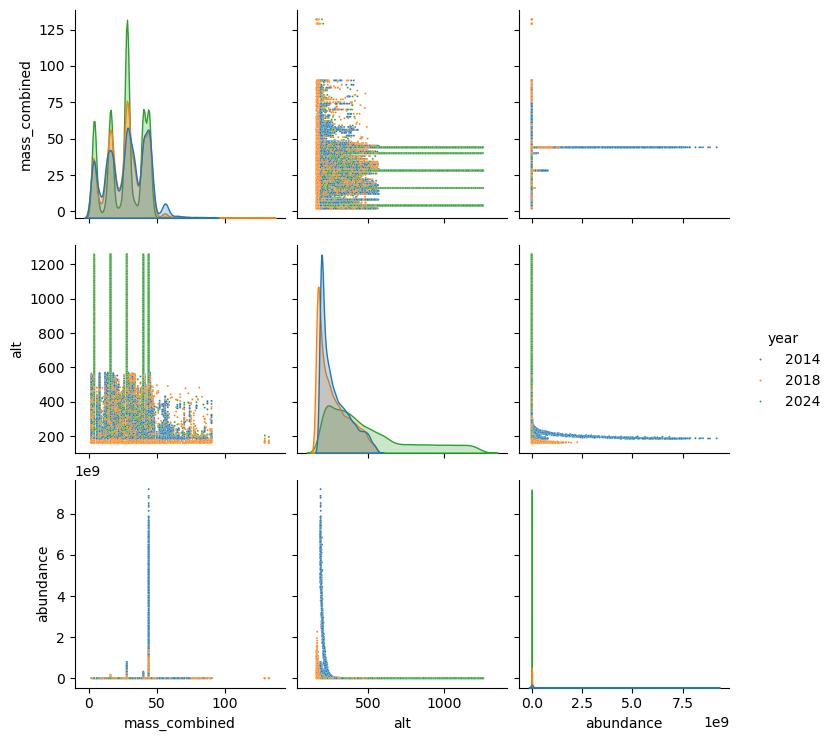

In [13]:
plt.figure(figsize=(40,40))
sns.pairplot(L2_sample_data, 
             vars=["mass_combined", "alt", "abundance"],     # list of features to plot
             hue='year',                                     # what feature to color by
             hue_order=['2014', '2018', '2024'],
             palette=sns.color_palette("tab10"),
             diag_kind='kde', 
             plot_kws={"s": 2})
plt.savefig("L2_pairplots.png")

#### Level 2 Pairplots
We can immediately make some new observations about how these three different features
relate and also about the differences between years.
- **altitude:** 2024 has observations at much higher altitudes than the other two years,
  while 2018 has observations at slightly lower altitudes than the others. The 2024
  altitude can likely be explained by MAVEN's orbit changing in 2019 so that it could
  serve better as a relay with rovers on the surface. The 2018 measurements at very low
  altitude is probably from MAVEN's periodic deep dives, where it goes slightly lower
  than a normal orbit. Since October 2014 is soon after MAVEN arrived at Mars, it may
  have not done any deep dives yet, while the altered 2024 orbit doesn't go down as far.
- **abundance:** we can see much higher abundance levels recorded in 2014 than other years.
  There is no clear explanation for this fact that I have found.
- **mass vs abundance:** As we might have hoped, we see higher abundances observed for certain
  masses (more investigation on this later).
- **mass vs altitude:** Lower masses are recorded at a wider range of altitudes and can
  be found higher up in the atmosphere. Interestingly enough, we see certain masses observed at
  much higher altitudes (more on this later shortly).

We can now make another pairplot looking at just the level 2 osion data:

<Figure size 4000x4000 with 0 Axes>

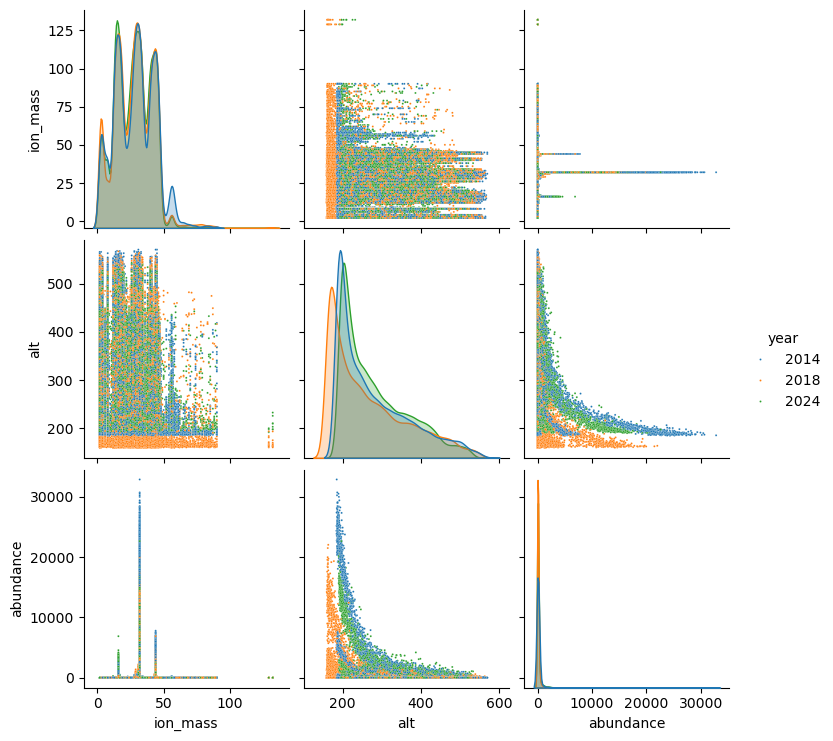

In [14]:
plt.figure(figsize=(40,40))
sns.pairplot(L2_osion_sample_data, 
             vars=["ion_mass", "alt", "abundance"], 
             hue='year',
             hue_order=['2014', '2018', '2024'],
             palette=sns.color_palette("tab10"),
             diag_kind='kde', 
             plot_kws={"s": 2})
plt.savefig("L2_osion_pairplots.png")

#### Level 2 osion Pairplots
With the csn data removed, we can see some significant differences (and also
start to explain some of our observations above).
- **altitude:** we still see the lower altitudes in 2018 (likely from the
  deep dives) but the altitude from 2024 now looks much more normal. This
  means that the csn data from 2024 was taken across a wider range of
  altitudes- in fact, these are the disinct spikes we saw in the mass vs
  altitude graph for all of the level 2 data. This may be because of the
  changed orbit or simply that the one month happens to contain an
  experiment run across a wider range of altitudes.
- **abundance:** the abundance data still has much larger counts from 2014,
  so this wasn't a product of the csn data.

### Level 2 Scatterplots
Now that we have used heatmaps and pairplots to get an overview of the data, we can take
a closer look using individual scatterplots, starting with the level 2 data. First we 
define a function that lets us generate a scatterplot, colored by a feature of our 
choice. Then we can plot 'mass' vs 'alt' using the level 2 and level 2 osion data:

In [ ]:
scatterplotsDir1 = part1Dir + "/scatterplots/"
os.chdir(scatterplotsDir1)

In [15]:
def overlayScatter(DataFrame, feature1, feature2, label):
    """Make a basic scatterplot of two variables, using a third as a color.

    Arguments:
    DataFrame -- pandas dataframe with data of interest
    feature1 -- name of column in dataframe to be plotted on x-axis
    feature2 -- name of column in dataframe to be plotted on y-axis
    label -- name of column in dataframe to use as color
    """
    # Get list of categories and marker colors to use
    categories = DataFrame[label].unique()
    marker_colors = ['orange', 'blue', 'green', 'red', 'purple']

    # Plot data for each category in different color
    fig = go.Figure()
    for category, marker_color in zip(categories, marker_colors):
        fig.add_trace(go.Scatter(
            x=DataFrame[DataFrame[label] == category][feature1],
            y=DataFrame[DataFrame[label] == category][feature2],
            mode='markers',
            marker={'size': 4},
            name=category,
            marker_color=marker_color))

    # Format figure, adding title and axes titles
    fig.update_layout(
        title="{} vs {} by {}".format(feature1, feature2, label),
        xaxis_title=feature1,
        yaxis_title=feature2,
        width=800,
        height=800)

    # PLOTLY_DISPLAY is global variable assigned at the start
    if PLOTLY_DISPLAY == True:
        fig.show()

    # Save file
    fig.write_html('{}vs{}by_{}_plotly_color_scatter.html'.format(feature1, feature2, label))

overlayScatter(L2_osion_sample_data, "ion_mass", "alt", "year")
overlayScatter(L2_sample_data, "mass_combined", "alt", "focusmode")

#### Mass vs Altitude for Level 2 / Level 2 osion
These plots show us more or less what we already found from the pairplots; there are
csn observations over a wider range of altitudes, with the osion data looking similar
for the three different months/years.

We now define a new function to let us create scatterplots side-by-side for each year.
Now we can explore more of the correlations we saw in the heatmap, with time,
altitude, local solar time, and spacecraft potential:

In [ ]:
def byYearScatter(DataFrame, feature1, feature2, label=None):
    """Create scatterplots for each year and an optional label.

    Arguments:
    DataFrame -- pandas dataframe with data of interest
    feature1 -- name of column in dataframe to be plotted on x-axis
    feature2 -- name of column in dataframe to be plotted on y-axis

    Keyword Arguments:
    label -- name of column in dataframe to use as color (default None)
    """
    # Make list of years and colors to use
    years = ['2014', '2018', '2024']
    marker_colors = ['orange', 'blue', 'green', 'red', 'purple']
    if label != None:
        categories = DataFrame[label].unique()
    # Generate plots, coloring by label if one is provided and otherwise by year
    fig = sp.make_subplots(rows=1, 
                           cols=5, 
                           subplot_titles=['2014', '', '2018', '', '2024'], 
                           column_widths=[2.5, 0.3, 2.5, 0.3, 2.5],
                           shared_yaxes=True)
    for year, marker_color, i in zip(years, marker_colors, range(3)):
        if label == None:
            fig.add_trace(go.Scatter(
                x=DataFrame[DataFrame['year'] == year][feature1],
                y=DataFrame[DataFrame['year'] == year][feature2],
                mode='markers',
                marker={'size': 4},
                marker_color=marker_color,), row=1, col=2*i+1)
        else:
            for category, marker_color in zip(categories, marker_colors):
                fig.add_trace(go.Scatter(
                x=DataFrame[(DataFrame['year'] == year) & (DataFrame[label] == category)][feature1],
                y=DataFrame[(DataFrame['year'] == year) & (DataFrame[label] == category)][feature2],
                name='{}_{}'.format(category, year),
                mode='markers',
                marker={'size': 4},
                marker_color=marker_color,), row=1, col=2*i+1)
                
    fig.update_layout(
        title="{} vs {} by year".format(feature1, feature2),
        xaxis_title=feature1,
        yaxis_title=feature2,
        width=2000,
        height=800)

    if PLOTLY_DISPLAY == True:
        fig.show()

    if label == None:
        fig.write_html('{}vs{}by_year_plotly.html'.format(feature1, feature2))
    else:
        fig.write_html('{}vs{}by_year_and_{}_plotly.html'.format(feature1, feature2, label))
    
byYearScatter(L2_osion_sample_data, 't_utc', 'SC_potential')
byYearScatter(L2_sample_data, 't_utc', 'lst')
overlayScatter(L2_osion_sample_data, 'alt', 'SC_potential', 'year')

#### Time, lst, SC_potential and alt
We can now attempt to explain the values observed in the heatmap:
- **SC_potential:** we can see that we have slightly different ranges of potential recorded for
  the three different years, with no clear trend. Looking at the altitude plot does show that
  since potential is larger at lower altitudes, we see the largest potentials in 2018 with the
  lowest altitudes. We also see larger potentials at the same altitudes for 2024 over 2018, and
  2018 over 2014. Therefore, it may be the case that spacecraft potential is actually increasing
  over time (*note: the plot is a little misleading since potential is negative, so lower points
  are actually "larger" values*)
- **local solar time:** the range of values for lst shifts over time, which is consistent with our
  hypothesis that this is due to MAVEN's orbit.

In the heatmap, we also saw that 't_tid' (time since start of test) has a negative correlation with
time, possibly indicating that tests are getting shorter. We investigate this now:

In [19]:
years = ['2014', '2018', '2024']
clrs = ['orange', 'blue', 'green']

# Create histogram for each year, plotting total test time for each experiment (tid)
fig = go.Figure()
for year, clr in zip(years, clrs):
    year_data = L2_sample_data[L2_sample_data['year'] == year]
    fig.add_trace(go.Histogram(
        x=year_data.groupby(["tid"])["t_tid"].max() - year_data.groupby(["tid"])["t_tid"].min(),
        name=year))

fig.update_layout(
    title="tid vs test time (s)",
    xaxis_title='test_time',
    yaxis_title='count',
    width=800,
    height=800)

if PLOTLY_DISPLAY == True:
    fig.show()
    
fig.write_html('test_times_hist_plotly.html')

#### Time vs t_tid
There are a few different test durations recorded, but there is no strong evidence that it
has changed much with time as almost all the tests had a duration of 1300-1500 seconds.
There are a few tests from 2024 that were much longer (likely the ones covering a wide
range of altitudes we saw earlier) and a couple from 2018 and 2024 that were shorter
which may have contributed to the statistic, but nothing extreme.

### Level 1b Pairplots
We now shift our attention to slightly lower level data, making similar plots for
level 1b. After looking at our available features, we choose some to pairplot:

In [20]:
os.chdir(hmppDir1)
L1b_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 37 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   t_utc           150000 non-null  datetime64[ns]
 1   t_unix          150000 non-null  float64       
 2   t_sclk_raw      150000 non-null  float64       
 3   t_sclk_cor      150000 non-null  float64       
 4   t_tid           150000 non-null  float64       
 5   tid             150000 non-null  int64         
 6   umkid           150000 non-null  int64         
 7   orbit           150000 non-null  int64         
 8   focus_mode      150000 non-null  object        
 9   multiplier      150000 non-null  int64         
 10  filament        150000 non-null  int64         
 11  temperature_s   150000 non-null  float64       
 12  mass            150000 non-null  float64       
 13  counts          150000 non-null  int64         
 14  cps_raw         150000 non-null  flo

<Figure size 4000x4000 with 0 Axes>

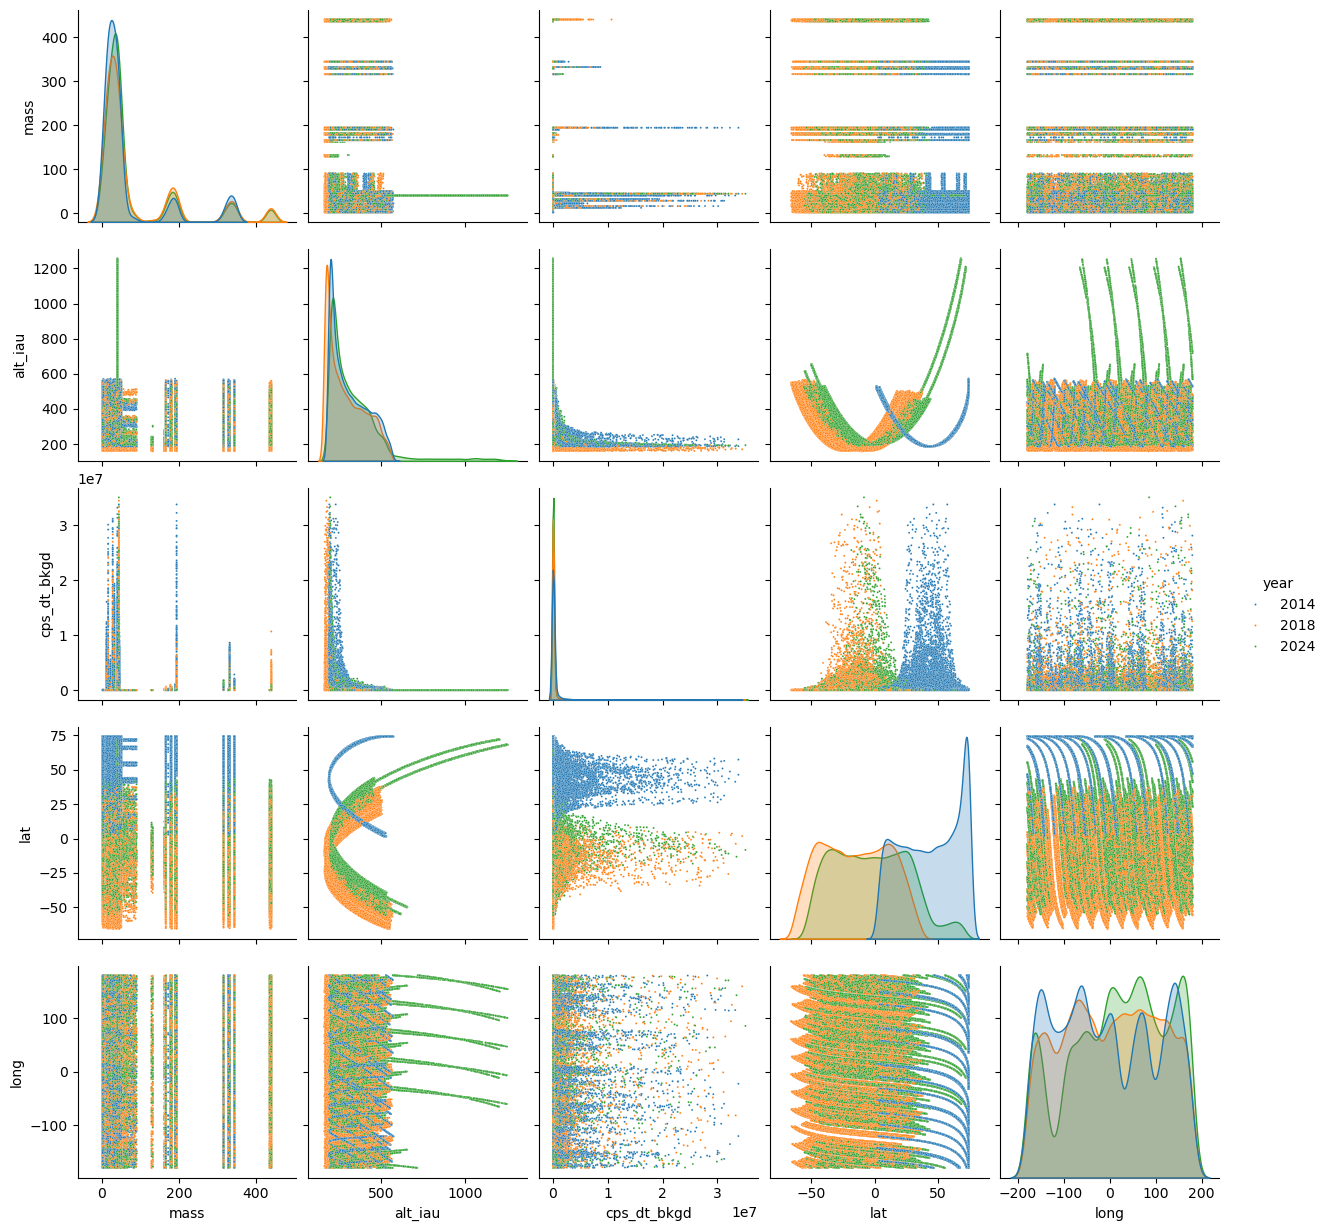

In [21]:
plt.figure(figsize=(40,40))
sns.pairplot(L1b_sample_data, 
             vars=["mass", "alt_iau", "cps_dt_bkgd", "lat", "long"], 
             hue='year',
             hue_order=['2014', '2018', '2024'],
             palette=sns.color_palette("tab10"),
             diag_kind='kde', 
             plot_kws={"s": 2})
plt.savefig("L1b_pairplots.png")

#### Level 1b Pairplot Summary
Latitude and longitude have also been included this time, so we have a little more to analyze.
- **mass:** the NGIMS mass spectrometer records masses between 2-150, but if we look closely we
  can see some over 400 in the pairplots. At level 1b, mass is still in m/z, leading to this result.
- **cps_dt_bkgd:** this is calibrated cps, which has a simple linear correlation with abundance. We
  can a similar mass vs cps relationship as we observed with mass vs abundance for the level 2
  pairplots, but because mass is in m/z it looks slightly different.
- **MAVEN orbit properties:** With latitude and longitude included, we can very clearly see how
  MAVEN's shifted orbits over time leads to data from generally different lats/longs for the
  three different years. Specifically, in the lat vs long and lat vs alt plots, each "band" likely
  represents a single experiment with the line showing MAVEN's path.

### Level 1b Scatterplots
We now construct some scatterplots for level 1b for features idenitfied from the heatmaps:

In [22]:
os.chdir(scatterplotsDir1)
byYearScatter(L1b_sample_data, 't_utc', 'vsc_iau', label='focus_mode')
byYearScatter(L1b_sample_data, 't_utc', 'sol_lat', label='focus_mode')
byYearScatter(L1b_sample_data, 't_utc', 'sza', label='focus_mode')

#### Time vs vsc, sol_lat, sza
All three of these variables have a strong correlation with time, which we can now explain with the plots.
- **sol_lat and sza:** these two are once again simply due to MAVEN's orbit; it doesn't start/end at the
  same time/place each time.
- **vsc_iau:** this is spacecraft velocity, which can't be easily explained by MAVEN's orbit. However,
  looking at the plot quickly reveals that this is due to the abnormal csn tests in January 2024- since
  MAVEN is going faster at lower altitudes, the high altitudes in the data also add entries with much
  lower velocity. Without these there would be basically zero correlation.

### Mass Plots
We now shift our attention to specifically invetsigate mass, as this is the most important feature of
the data. We first construct a plot showing each mass and its frequency in the data, focusing on the
level 2 osion data.

In [23]:
L2_osion_sample_data['ion_mass'].describe()

count    150000.000000
mean         27.571183
std          14.208857
min           2.000000
25%          16.000000
50%          28.000000
75%          39.000000
max         132.000000
Name: ion_mass, dtype: float64

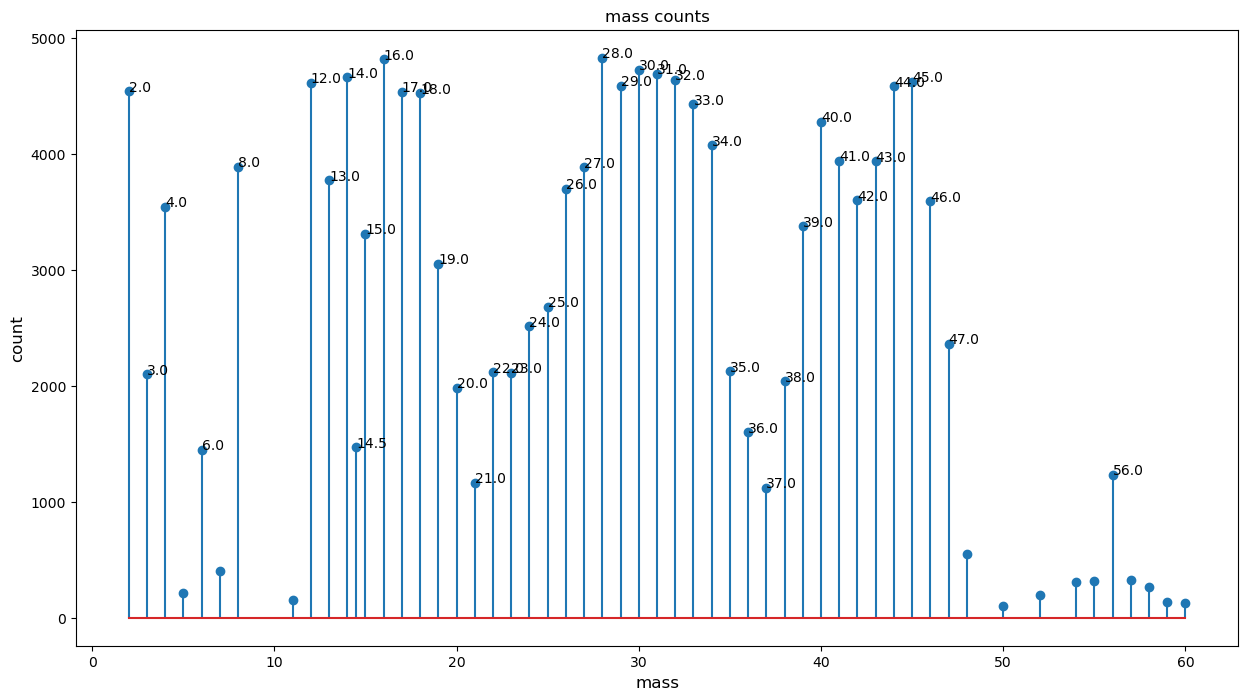

<Figure size 640x480 with 0 Axes>

In [602]:
# Create dataframe with each mass and its count
mass_count = pd.DataFrame({'count': L2_osion_sample_data.groupby('ion_mass').size()})
# Filter out low counts
mass_count = mass_count[mass_count['count'] > 100]

# Make stemplot using counts
plt.figure(figsize=(15,8))
plt.stem(mass_count.index, mass_count.values)
plt.xticks(np.arange(0, 70, step=10))
plt.xlabel('mass', fontsize = 12)
plt.ylabel('count', fontsize = 12)
plt.title("mass counts")
for x,y in zip(mass_count.index, mass_count['count']):
    if y>1000:
        label = "{:.1f}".format(float(x))
        plt.annotate(label, (x,y))
plt.show()
plt.savefig('mass_counts.png')

#### Mass Counts Summary
We can see a large number of masses with fairly high counts. This is because NGIMS is a 
quadrupole mass spectrometer, which selects certain masses and then measures their counts.
For this reason, this plot simply shows us how many times each mass was selected to be
measured. By instead making a plot with average abundance instead of count, we can get
a better idea of which masses are selected a lot:

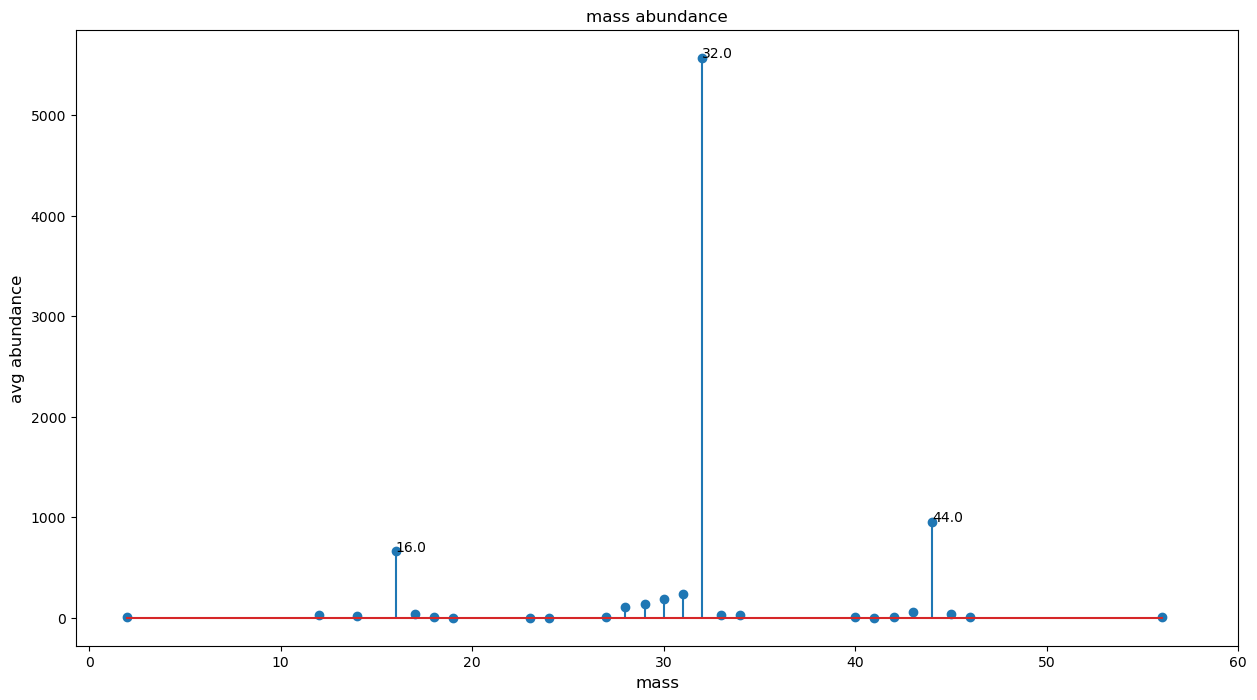

<Figure size 640x480 with 0 Axes>

In [606]:
# Create dataframe of masses and their average abundance and filter
mass_abundance = pd.DataFrame({'abundance': L2_osion_sample_data.groupby('ion_mass')['abundance'].mean()})
mass_abundance = mass_abundance[mass_abundance['abundance'] > 1]

plt.figure(figsize=(15,8))
plt.stem(mass_abundance.index, mass_abundance.values)
plt.xticks(np.arange(0, 70, step=10))
plt.xlabel('mass', fontsize = 12)
plt.ylabel('avg abundance', fontsize = 12)
plt.title("mass abundance")
for x,y in zip(mass_abundance.index, mass_abundance['abundance']):
    if y>500:
        label = "{:.1f}".format(float(x))
        plt.annotate(label, (x,y))
plt.show()
plt.savefig('mass_abundance.png')

#### Mass Abundance Summary
Now we can much more clearly see which masses actually have high abundances in the atmosphere. We see
peaks at mass 16, 32, and 44, corresponding to oxygen and carbon dioxide. However, **this is not the
full picture-** we are missing the neutral data that accounts for some of the most abundant species.
Also, it is benefical to use a log scale for abundance since values get very large. Incorporating 
these changes, we get the following plot:

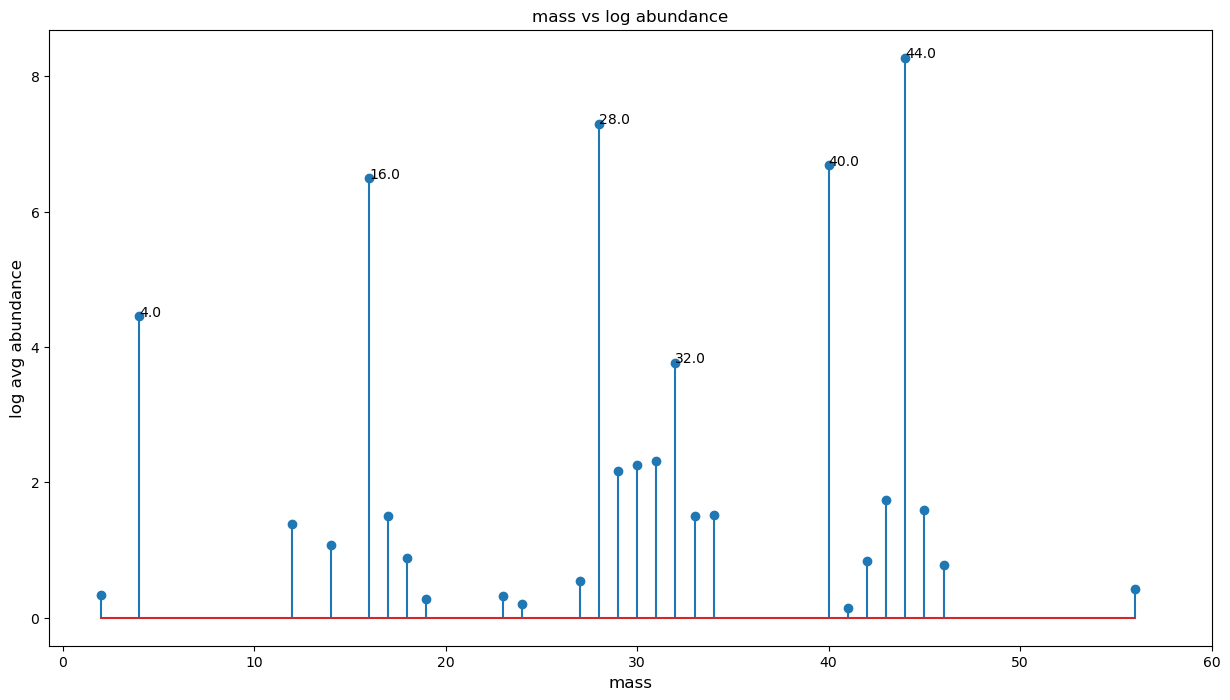

<Figure size 640x480 with 0 Axes>

In [779]:
# Create dataframe of all masses with the log of their average abundance
mass_log_abundance = pd.DataFrame({'log_abundance': np.log10(L2_sample_data.groupby('mass_combined')['abundance'].mean())})
# Filter out low abundance masses
mass_log_abundance = mass_log_abundance[mass_log_abundance['log_abundance'] > 0]

plt.figure(figsize=(15,8))
plt.stem(mass_log_abundance.index, mass_log_abundance.values)
plt.xticks(np.arange(0, 70, step=10))
plt.xlabel('mass', fontsize = 12)
plt.ylabel('log avg abundance', fontsize = 12)
plt.title('mass vs log abundance')
for x,y in zip(mass_log_abundance.index, mass_log_abundance['log_abundance']):
    if y>3:
        label = "{:.1f}".format(float(x))
        plt.annotate(label, (x,y))
plt.show()
plt.savefig('all_mass_log_abundance.png')

#### All Mass vs Log Abundance Summary
With these changes, we now see a graph more along the lines of what we would expect, with
CO2 at the top followed by Nitrogen, Argon and Oxygen.

## Data Visualization Using Dimensionality Reduction (PCA)
Now that we have a better understanding of the data and explored all of its key features, we can
attempt to use **PCA (Principal Component Analysis)** to better visualize the data. There is a
designated section for dimensionality reduction later, but here's the big idea:
- When datasets have lots of features, they can be extremely hard to visualize with only a few
  dimensions.
- Dimensionality Reduction techniques attempt to project the data into a lower dimensional space
  while allowing us to preserve as much of the structure as possible.
- PCA specifically creates a "shadow" of the data that is as spread out as possible.

### Initial PCA with time variables
We first need to process our data. Then, after putting it through our PCA model, we can start
generating plots!

#### Preprocessing of Data and PCA Model Fitting
First, we need to take our sample data and filter out some of the variables. We remove features
that only appear in one focus mode (since they have a lot of null entries), categorical features
(since they don't work well with PCA), and finally extra time variables.

Next, since we are only interested in how variables change (not their absolute magnitude), we
standardize the data and then apply the PCA transformation.

In [29]:
# Select only certain features from the data, still including time variable(s)
L2_pdata_t = L2_sample_data.drop(['t_utc', 't_sclk_cor', 'orbit', 'focusmode', 'mass', 'species', 
                                                'cps_dt_bkd', 'quality', 't_sclk', 'ion_mass', 'cps_dt', 
                                                'sensitivity', 'SC_potential', 't_sclk_combined', 'year'], axis=1)

def applyPCA(DataFrame, n=None):
    """Create a PCA model for data and return transformation.
    
    Arguments:
    DataFrame -- pandas dataframe with selected data
    
    Keyword Arguments:
    n -- number of components (dimensions) to transform to. If None, will
    preserve number of dimensions (default None)

    Return Values:
    pca -- data transformed by model
    pca_model -- PCA model fitted to data in DataFrame
    """
    # Scale data and put into dataframe
    standardized_data = StandardScaler().fit_transform(DataFrame)
    standardized_data = pd.DataFrame(standardized_data, columns=DataFrame.columns)
    # Create PCA model
    if n == None:
        pca_model = PCA()
    else:
        pca_model = PCA(n)
    # Transform data
    pca = pca_model.fit_transform(standardized_data)

    return pca, pca_model

L2pca_t, L2pca_model_t = applyPCA(L2_pdata_t)

#### PCA Model Summary
Now that we have created our model and gotten our transformation of the data, we can get an idea
of what the transformation has done. PCA generates **principal components**, with each one explaining
some portion of the variance of the original data. We can make a plot showing the component number
and how much variance it explains, as well as the total amount of explained variance.

Finally, we can see how much "weight" each of our original features has on the new components
and view it in a dataframe.

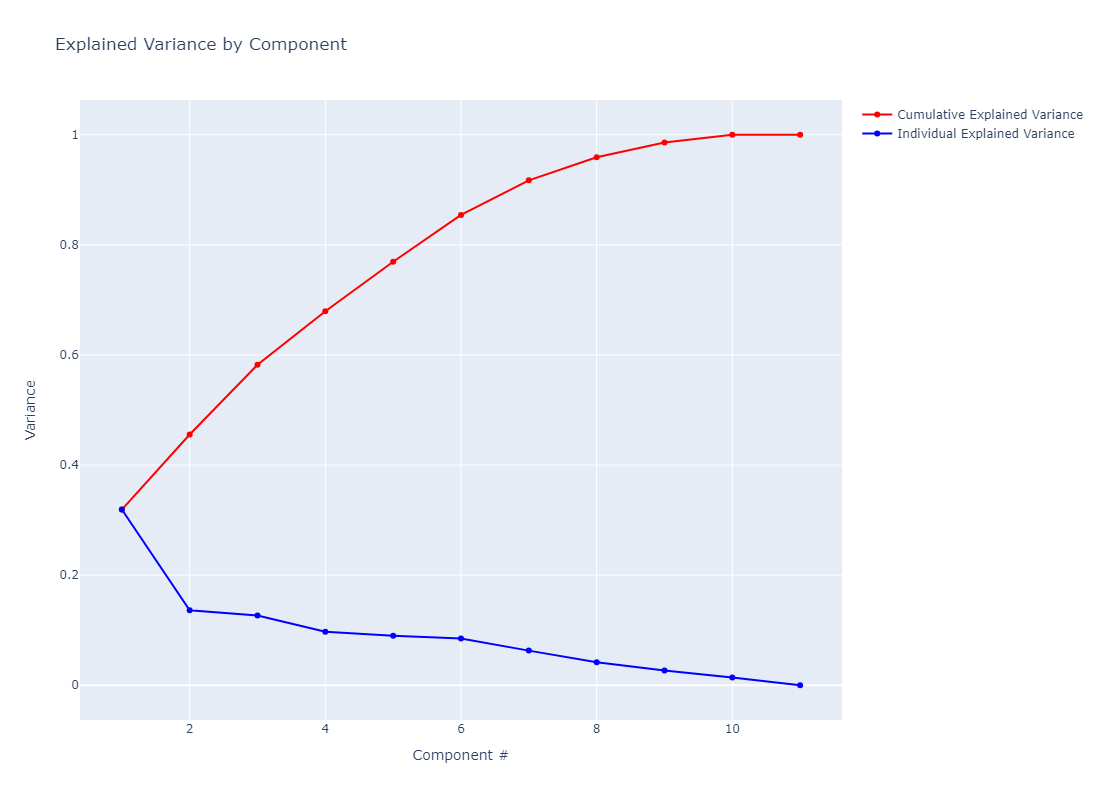

t_unix     t_tid       tid       alt       lst  \
Principal Component 1   0.508834  0.349691  0.511953  0.307516  0.063661   
Principal Component 2   0.144639  0.118190  0.104991  0.335265  0.566207   
Principal Component 3   0.035145  0.285589  0.053520  0.429516  0.538220   
Principal Component 4   0.016703  0.115708  0.009993  0.049395  0.120686   
Principal Component 5   0.001214  0.195539  0.003644  0.005478  0.051611   
Principal Component 6   0.038069  0.072223  0.036903  0.043818  0.039375   
Principal Component 7   0.023479  0.599729  0.030378  0.190298  0.014352   
Principal Component 8   0.175556  0.368364  0.177484  0.600122  0.041352   
Principal Component 9   0.308527  0.478604  0.299794  0.325458  0.414635   
Principal Component 10  0.296038  0.030301  0.323524  0.319178  0.437987   
Principal Component 11  0.709228  0.000222  0.703970  0.000410  0.035015   

                            long       lat       sza  abundance  precision  \
Principal Component 1   0.087535  0.079392  0.354050   0.051803   0.339910   
Principal Component 2   0.079457  0.672047  0.022524   0.100093   0.219727   
Principal Component 3   0.073206  0.251148  0.573023   0.109130   0.167664   
Principal Component 4   0.153226  0.036189  0.053259   0.600324   0.137933   
Principal Component 5   0.956851  0.124866  0.020429   0.096169   0.010892   
Principal Component 6   0.021780  0.022702  0.011691   0.775148   0.131088   
Principal Component 7   0.156548  0.378038  0.140450   0.067625   0.628313   
Principal Component 8   0.119466  0.134443  0.072748   0.014711   0.613285   
Principal Component 9   0.048072  0.545231  0.091720   0.001577   0.004963   
Principal Component 10  0.007654  0.055858  0.713403   0.010182   0.028676   
Principal Component 11  0.000062  0.013203  0.004659   0.000206   0.000206   

                        mass_combined  
Principal Component 1        0.023466  
Principal Component 2        0.065796  
Principal Component 3        0.058001  
Principal Component 4        0.749792  
Principal Component 5        0.134597  
Principal Component 6        0.607731  
Principal Component 7        0.126240  
Principal Component 8        0.161733  
Principal Component 9        0.000008  
Principal Component 10       0.004490  
Principal Component 11       0.000223

In [30]:
def PCA_Summary(pca_model, columns, name):
    """Generate plot showing explained variance for a PCA model and influence of each feature on the components.
    
    Arguments:
    pca_model -- PCA model fitted to the data
    columns -- features of the original data
    name -- string of name to associate with model
    """

    fig = go.Figure()

    # Plot cumulative explained variance
    fig.add_trace(go.Scatter(
        x=list(range(1,len(pca_model.explained_variance_ratio_ )+1)),
        y=np.cumsum(pca_model.explained_variance_ratio_),
        name='Cumulative Explained Variance',
        mode='lines+markers',
        marker_color='red'))

    # Plot individual explained variance
    fig.add_trace(go.Scatter(
        x=list(range(1,len(pca_model.explained_variance_ratio_ )+1)),
        y=pca_model.explained_variance_ratio_,
        name='Individual Explained Variance',
        mode='lines+markers',
        marker_color='blue'))
    
    fig.update_layout(
        title='Explained Variance by Component',
        xaxis_title='Component #',
        yaxis_title='Variance',
        width=800,
        height=800)
    
    fig.show()
    
    fig.write_html('PCA_variance_{}.html'.format(name))

    # Generate dataframe with principal compenents and weights with original features
    pc_df = pd.DataFrame(abs(pca_model.components_), columns=columns, 
                     index = list('Principal Component {}'.format(i+1) for i in range(len(columns))))
    return pc_df

PCA_Summary(L2pca_model_t, L2_pdata_t.columns, 'L2time')

As we can see, the first principal component explains much more variance than the others.
Unsurpirsingly, it is heavily influenced by time, with a value of over 0.5 fot t_unix
and tid for the first component. This makes sense as our data comes from three 
discrete time periods from three different years. Other time-correlated variables like 
sza and lst also have a lot of weight in the first few components.

#### PCA Scatterplots
Now that we have our transformed data, we can start plotting it to see how it did
representing the data. We define a function that colors the transformed data by
year and focus mode.

In [ ]:
pcaplotsDir1 = part1Dir + "/pca_plots/"
os.chdir(pcaplotsDir1)

In [31]:
def PCA_Scatter(DataFrame, pca, filename, level):
    """Creates a scatterplot of PCA transformed data, coloring by year and focus mode.
    
    Arguments:
    DataFrame -- pandas dataframe with original data
    pca -- data transformed by PCA model
    filename -- name to use with plot title and saved file
    level -- level of data used (1=level 1a, 2=level 2)
    """

    # Create dictionary to map year/focus mode to distinct color
    color_dict = {
                    '2014': {'osion': 'cyan', 'csn': 'blue'}, 
                    '2018': {'osion': 'pink', 'csn': 'orange'}, 
                    '2024': {'osion': 'lightseagreen', 'csn': 'darkseagreen'}
                 }

    if level == 2:
        focusmode='focusmode'
    else:
        focusmode='focus_mode'
    
    fig = go.Figure()

    # Plot PCA data for each year and focus mode permutation
    for year in color_dict.keys():
        for mode in color_dict[year].keys():
            fig.add_trace(go.Scatter(
                x=pca[(DataFrame['year'] == year) & (DataFrame[focusmode] == mode), 0],
                y=pca[(DataFrame['year'] == year) & (DataFrame[focusmode] == mode), 1],
                name='{}_{}'.format(year, mode),
                mode='markers',
                marker={'size': 4},
                marker_color=color_dict[year][mode]))
    
    
    fig.update_layout(
        title='L{} 2D PCA Scatter {}'.format(level, filename),
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        width=800,
        height=800)
    
    if PLOTLY_DISPLAY == True:
        fig.show()
    
    fig.write_html('L{}_PCA_2D_Scatter_{}.html'.format(level, filename))

PCA_Scatter(L2_sample_data, L2pca_t, 'time', 2)

##### PCA Scatterplot Summary
The PCA model does a good job distinguishing the data by year, but because the times
are so distinct this dominates the model and there is not much else to consider (we
already knew the data was from three different months/years).

### PCA Model with no time variables
We now try the same procedure on the data with all time variables removed to see
if we can get some better grouping. We remove all time variables, fit our model,
and generate our plot and summary:

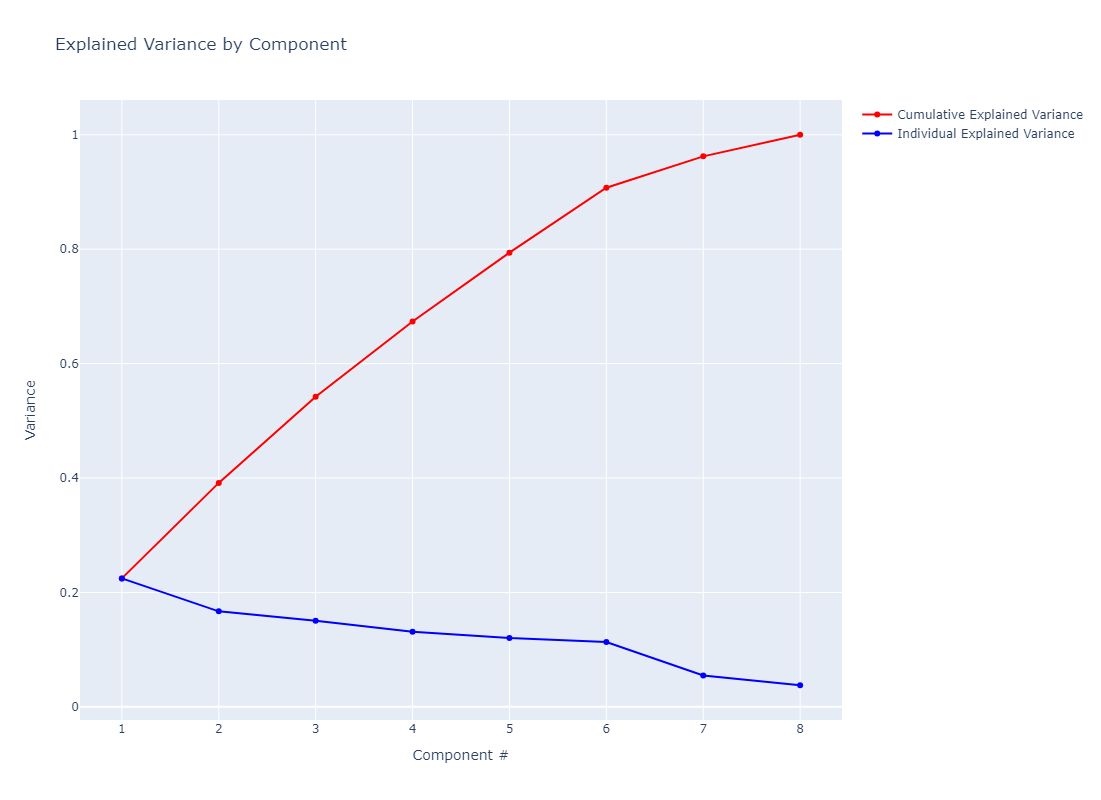

alt       lst      long       lat       sza  \
Principal Component 1  0.496425  0.455895  0.172773  0.269759  0.407352   
Principal Component 2  0.461618  0.397098  0.111121  0.424828  0.638824   
Principal Component 3  0.161532  0.436191  0.259328  0.611148  0.157673   
Principal Component 4  0.023847  0.224867  0.134122  0.224344  0.016893   
Principal Component 5  0.081255  0.053706  0.866838  0.028438  0.005325   
Principal Component 6  0.167962  0.145138  0.337177  0.188100  0.043352   
Principal Component 7  0.684760  0.000651  0.083629  0.208048  0.177682   
Principal Component 8  0.100500  0.608026  0.021706  0.493401  0.606089   

                       abundance  precision  mass_combined  
Principal Component 1   0.036870   0.525138       0.006009  
Principal Component 2   0.066548   0.145045       0.053226  
Principal Component 3   0.424137   0.304943       0.212482  
Principal Component 4   0.453855   0.279927       0.771958  
Principal Component 5   0.347075   0.246646       0.238688  
Principal Component 6   0.697714   0.196133       0.523928  
Principal Component 7   0.028287   0.651130       0.156474  
Principal Component 8   0.016379   0.092570       0.010353

In [32]:
L2_pdata_nt = L2_pdata_t.drop(['t_unix', 'tid', 't_tid'], axis=1)

L2pca_nt, L2pca_model_nt = applyPCA(L2_pdata_nt)
PCA_Scatter(L2_sample_data, L2pca_nt, 'no_time', 2)
PCA_Summary(L2pca_model_nt, L2_pdata_nt.columns, 'L2notime')

#### Model Summary
With the time variables removed, we can see tighter grouping between the data from the
three years. However, looking at the composition of our components, we can see that
they are still largely affected by variables that we know to be time-correlated, like
'lst' and 'sza'. 

### Additional Scatterplots
We now define one more function to allow us generate a scatterplot coloring by a third
feature of our choice. We also can use the `px.scatter()` function so that we are able to
include hover data for our points and look for patterns.

In [343]:
def PCA_ScatterBy(DataFrame, features, pca, pca_model, hue, filename):
    """Creates a scatterplot of PCA transformed data, coloring by a feature in the original data.
    
    Arguments:
    DataFrame -- pandas dataframe with the original data
    pca -- PCA transformed data
    pca_model -- PCA model fitted to the data
    hue -- column name in DataFrame used for color
    filename -- string that is name to use for plot title and saved file
    """
    # Create hover data for plot
    hover_data = {feat: DataFrame[feat] for feat in DataFrame.columns}

    # Get vectors for original features and total variance
    loadings = pca_model.components_.T * np.sqrt(pca_model.explained_variance_)
    total_var = pca_model.explained_variance_ratio_[:2].sum() * 100

    # Plot data, coloring by hue and including hover data
    fig = px.scatter(pca, x=0, y=1, height=800, width=1000, color=DataFrame[hue], color_continuous_scale='plasma', 
                     labels={'color': hue}, hover_data=hover_data, title='PCA 2D Scatter {} by {} TEV {:.2f}%'.format(filename, hue, total_var))

    # Add vectors for each feature that show their influence on projected data
    for j, feature in enumerate(features):
        fig.add_shape(type='line', x0=0, y0=0, x1=loadings[j, 0]*5, y1=loadings[j, 1]*5)
        fig.add_annotation(x=loadings[j, 0]*5, y=loadings[j, 1]*5,ax=0, ay=0, xanchor="center", yanchor="bottom", text=feature, bgcolor='white')
    
    if PLOTLY_DISPLAY == True:
        fig.show()
    
    fig.write_html('PCA_2D_Scatter_{}_by{}.html'.format(filename, hue))

In [36]:
PCA_ScatterBy(L2_sample_data, L2_pdata_t.columns, L2pca_t, L2pca_model_t, 'mass_combined', 'L2time')
PCA_ScatterBy(L2_sample_data, L2_pdata_t.columns, L2pca_t, L2pca_model_t, 'alt', 'L2time')
PCA_ScatterBy(L2_sample_data, L2_pdata_t.columns, L2pca_t, L2pca_model_t, 'long', 'L2time')
PCA_ScatterBy(L2_sample_data, L2_pdata_t.columns, L2pca_t, L2pca_model_t, 'lat', 'L2time')

#### Time PCA Summary
- **mass:** mass does not have much influence on the structure data structure as they are largely mixed together
- **alt:** the high altitudes from the 2024 csn data are once again very noticeable
- **long:** no clear trend, although we can see some slight local grouping for the left and top right
- **lat:** fairly distinct grouping within each cluster
Overall, this PCA is not effective due to the time variables, but we can still see some local trends.

In [37]:
PCA_ScatterBy(L2_sample_data, L2_pdata_nt.columns, L2pca_nt, L2pca_model_nt, 'mass_combined', 'L2_no_time')
PCA_ScatterBy(L2_sample_data, L2_pdata_nt.columns, L2pca_nt, L2pca_model_nt, 'alt', 'L2_no_time')
PCA_ScatterBy(L2_sample_data, L2_pdata_nt.columns, L2pca_nt, L2pca_model_nt, 'long', 'L2_no_time')
PCA_ScatterBy(L2_sample_data, L2_pdata_nt.columns, L2pca_nt, L2pca_model_nt, 'lat', 'L2_no_time')

#### No Time PCA Summary
- **mass:** no clear trends with mass
- **alt:** we still see the 2024 csn data's influence, but all of the data is at least slightly spread out by altitude
- **long:** there are some good local trends, and we can even see some branches of data representing distinct experiments (tids)
- **lat:** latitude provides good separation and there are some tids that can be seen very clearly.

With all the time variables removed, we start to see some more interesting features begin to influence the data. With that
being said, we still don't see very good grouping by mass.

### Level 2 osion PCA
We now construct PCA transformed data just using entries from the osion focus mode. While we are losing a lot
of useful data, we can avoid the irregular tids from January 2024 and hopefully see some clearer trends. We
begin by transforming the data and viewing our summary and initial scatterplot.

In [38]:
L2_osion_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   t_utc         150000 non-null  datetime64[ns]
 1   t_unix        150000 non-null  float64       
 2   t_tid         150000 non-null  float64       
 3   tid           150000 non-null  int64         
 4   orbit         150000 non-null  int64         
 5   focusmode     150000 non-null  object        
 6   alt           150000 non-null  float64       
 7   lst           150000 non-null  float64       
 8   long          150000 non-null  float64       
 9   lat           150000 non-null  float64       
 10  sza           150000 non-null  float64       
 11  abundance     150000 non-null  float64       
 12  precision     150000 non-null  float64       
 13  quality       150000 non-null  object        
 14  t_sclk        150000 non-null  float64       
 15  ion_mass      150

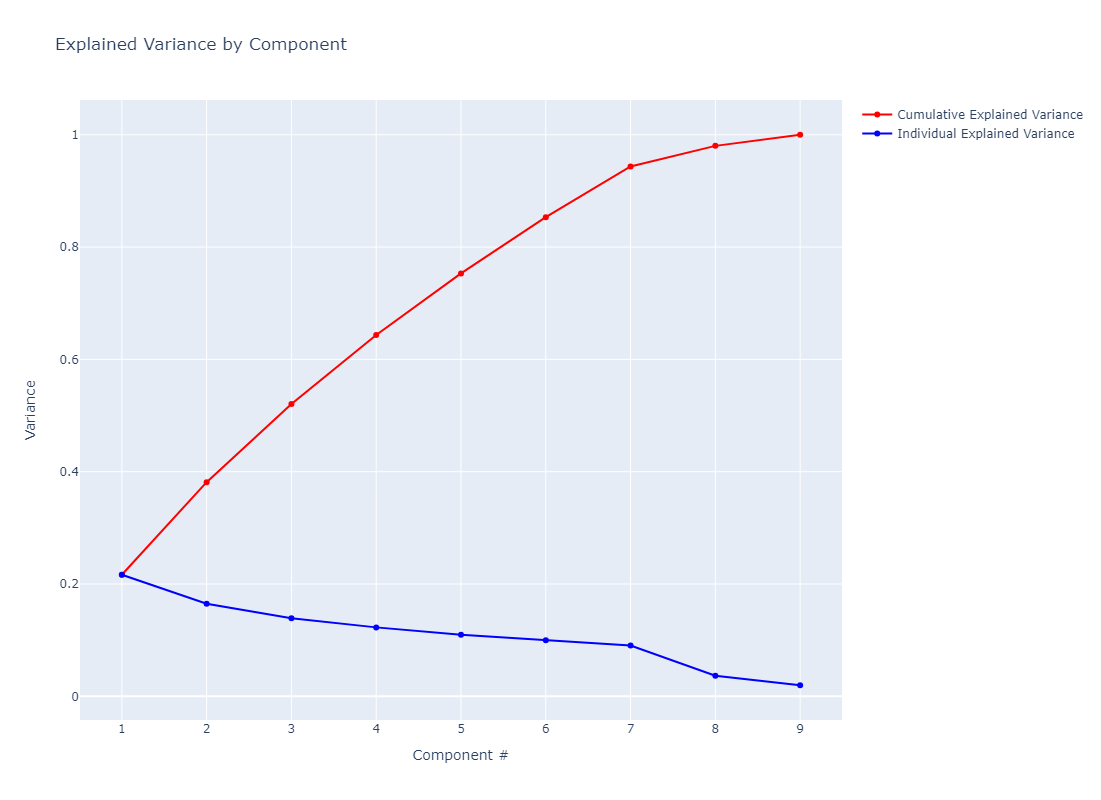

alt       lst      long       lat       sza  \
Principal Component 1  0.349894  0.041461  0.072728  0.454619  0.481175   
Principal Component 2  0.009632  0.778793  0.052440  0.329466  0.498733   
Principal Component 3  0.526789  0.087897  0.163815  0.334326  0.252090   
Principal Component 4  0.340666  0.040261  0.142799  0.224466  0.033580   
Principal Component 5  0.024890  0.057861  0.961069  0.086661  0.089608   
Principal Component 6  0.390633  0.035763  0.129176  0.260198  0.082183   
Principal Component 7  0.295902  0.011552  0.051074  0.232914  0.039412   
Principal Component 8  0.464682  0.301199  0.042246  0.617803  0.188694   
Principal Component 9  0.164986  0.535662  0.000819  0.107111  0.634915   

                       abundance  precision  ion_mass  SC_potential  
Principal Component 1   0.054960   0.044253  0.084192      0.648298  
Principal Component 2   0.123385   0.043716  0.043916      0.119550  
Principal Component 3   0.484471   0.266287  0.453846      0.031804  
Principal Component 4   0.470408   0.707659  0.289448      0.067658  
Principal Component 5   0.005499   0.066207  0.227789      0.023199  
Principal Component 6   0.251248   0.233107  0.790396      0.113111  
Principal Component 7   0.679355   0.604739  0.150343      0.063727  
Principal Component 8   0.031040   0.002116  0.044612      0.520885  
Principal Component 9   0.010807   0.002183  0.004454      0.520686

In [39]:
L2_osion_pdata_nt = L2_osion_sample_data.drop(['t_utc', 't_unix', 't_tid', 'tid', 'orbit', 'focusmode', 
                                             'quality', 't_sclk', 'cps_dt', 'sensitivity', 'year'], axis=1)
L2pca_ion_nt, L2pca_model_ion_nt = applyPCA(L2_osion_pdata_nt)
PCA_Scatter(L2_osion_sample_data, L2pca_ion_nt, 'osion_no_time', 2)
PCA_Summary(L2pca_model_ion_nt, L2_osion_pdata_nt.columns, 'L2osion_notime')

#### Initial Summary
Even with the time variables removed, we can still see three fairly distinct clusters, and looking
at the influence of each component we can once again see a lot of weight on 'lst' and 'sza' in the
first two components. We can make additional scatterplots to try to find other trends:

In [40]:
PCA_ScatterBy(L2_osion_sample_data, L2_osion_sdp_nt, L2osion_notime_pca, L2osion_notime_pca_model, 'abundance', 'L2osion_no_time')
PCA_ScatterBy(L2_osion_sample_data, L2_osion_sdp_nt, L2osion_notime_pca, L2osion_notime_pca_model, 'ion_mass', 'L2osion_no_time')
PCA_ScatterBy(L2_osion_sample_data, L2_osion_sdp_nt, L2osion_notime_pca, L2osion_notime_pca_model, 'SC_potential', 'L2osion_no_time')
PCA_ScatterBy(L2_osion_sample_data, L2_osion_sdp_nt, L2osion_notime_pca, L2osion_notime_pca_model, 'alt', 'L2osion_no_time')

#### Level 2 osion Summary
- **abundance:** the small group of very high abundance readings from 2014 can be seen clearly, may be better with log scale
- **ion_mass:** still no clear trends in the data, we can see that a lot of the weight is in later principal components
- **SC_potential:** we can clearly see larger spacecraft potentials (more negative) on the right
- **alt:** there is some local structure but no clear trends for the full data

With the csn data removed, we get less influence by time, but it is stil hard to find clear cluster by mass and abundance.

### Level 1b PCA
We move on to one final PCA using the level 1b data. First, we can remind ourselves what all the features are and then
choose which to drop. We once again drop time variables, as well as categorical and redundant features. Then we create
our model and summary.

In [41]:
L1b_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 37 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   t_utc           150000 non-null  datetime64[ns]
 1   t_unix          150000 non-null  float64       
 2   t_sclk_raw      150000 non-null  float64       
 3   t_sclk_cor      150000 non-null  float64       
 4   t_tid           150000 non-null  float64       
 5   tid             150000 non-null  int64         
 6   umkid           150000 non-null  int64         
 7   orbit           150000 non-null  int64         
 8   focus_mode      150000 non-null  object        
 9   multiplier      150000 non-null  int64         
 10  filament        150000 non-null  int64         
 11  temperature_s   150000 non-null  float64       
 12  mass            150000 non-null  float64       
 13  counts          150000 non-null  int64         
 14  cps_raw         150000 non-null  flo

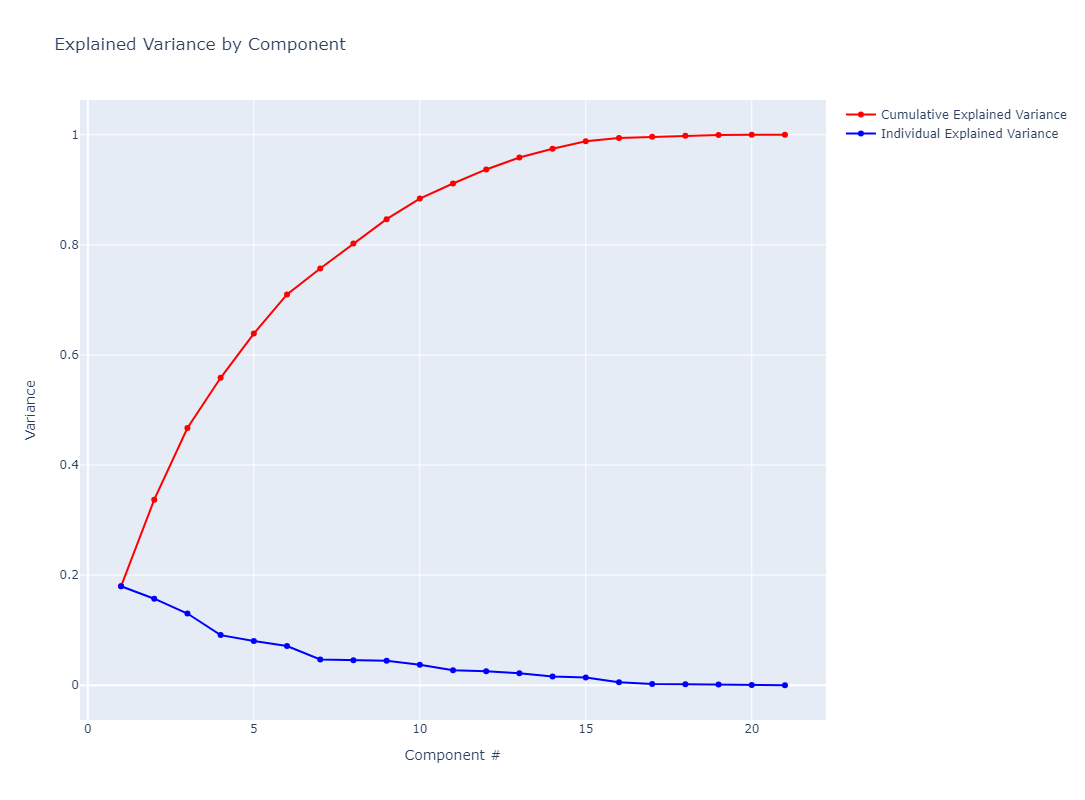

filament  temperature_s      mass    counts  \
Principal Component 1   0.017752       0.342143  0.049881  0.075659   
Principal Component 2   0.017532       0.153116  0.038945  0.015585   
Principal Component 3   0.087012       0.164860  0.029663  0.234421   
Principal Component 4   0.173670       0.011006  0.020777  0.618910   
Principal Component 5   0.058548       0.310727  0.055976  0.195897   
Principal Component 6   0.023059       0.035662  0.012153  0.041434   
Principal Component 7   0.153670       0.010851  0.977053  0.015358   
Principal Component 8   0.965691       0.035026  0.155104  0.094817   
Principal Component 9   0.021315       0.406310  0.103038  0.041570   
Principal Component 10  0.013976       0.048373  0.020758  0.000613   
Principal Component 11  0.001178       0.321126  0.039597  0.032542   
Principal Component 12  0.006882       0.021003  0.001448  0.002556   
Principal Component 13  0.000374       0.051814  0.006233  0.008204   
Principal Component 14  0.027088       0.143100  0.003168  0.017534   
Principal Component 15  0.002858       0.021039  0.003035  0.001960   
Principal Component 16  0.004414       0.033022  0.000260  0.000986   
Principal Component 17  0.001331       0.140393  0.001092  0.000341   
Principal Component 18  0.001698       0.641373  0.002403  0.048652   
Principal Component 19  0.006781       0.040041  0.005493  0.707911   
Principal Component 20  0.000053       0.068152  0.000533  0.004454   
Principal Component 21  0.000776       0.004689  0.000065  0.003484   

                        cps_dt_bkgd   alt_iau   vsc_iau      ram1  \
Principal Component 1      0.067619  0.015599  0.168246  0.012617   
Principal Component 2      0.014109  0.098975  0.041856  0.093241   
Principal Component 3      0.223553  0.531299  0.517143  0.417479   
Principal Component 4      0.622425  0.101989  0.184161  0.184938   
Principal Component 5      0.203824  0.101952  0.082788  0.116155   
Principal Component 6      0.044637  0.069801  0.053582  0.015280   
Principal Component 7      0.024928  0.025401  0.000067  0.014289   
Principal Component 8      0.105093  0.068269  0.073822  0.087648   
Principal Component 9      0.047110  0.298151  0.133435  0.171655   
Principal Component 10     0.000075  0.000862  0.003082  0.018856   
Principal Component 11     0.050855  0.024692  0.164776  0.708780   
Principal Component 12     0.004813  0.024736  0.018702  0.112231   
Principal Component 13     0.013904  0.030120  0.051107  0.178521   
Principal Component 14     0.042488  0.393347  0.295127  0.420748   
Principal Component 15     0.007752  0.070066  0.030604  0.074221   
Principal Component 16     0.007270  0.181762  0.109090  0.004346   
Principal Component 17     0.000406  0.017683  0.011092  0.016691   
Principal Component 18     0.050160  0.153836  0.190331  0.004026   
Principal Component 19     0.702255  0.007579  0.023250  0.013964   
Principal Component 20     0.003604  0.595765  0.675590  0.036447   
Principal Component 21     0.002279  0.118511  0.110630  0.003840   

                        ram2_rot_angle   sol_lon  ...       lst     x_iau  \
Principal Component 1         0.219841  0.165138  ...  0.096213  0.015620   
Principal Component 2         0.456656  0.319048  ...  0.106227  0.049376   
Principal Component 3         0.115839  0.059071  ...  0.029694  0.034827   
Principal Component 4         0.033790  0.005822  ...  0.214157  0.036198   
Principal Component 5         0.020101  0.004627  ...  0.675199  0.057444   
Principal Component 6         0.018818  0.019956  ...  0.034767  0.697996   
Principal Component 7         0.000719  0.009502  ...  0.033362  0.002395   
Principal Component 8         0.003450  0.010727  ...  0.009447  0.001533   
Principal Component 9         0.026760  0.008128  ...  0.165507  0.103088   
Principal Component 10        0.017684  0.668474  ...  0.005306  0.038061   
Principal Component 11        0.018278  0.043811  ...  0.013557  0.162547   
Principal Componen

In [42]:
L1b_pdata_nt = L1b_sample_data.drop(['t_utc', 't_unix', 't_sclk_raw', 't_sclk_cor', 't_tid', 'tid', 
                                   'umkid', 'orbit', 'focus_mode', 'multiplier', 'cps_raw', 'cps_raw_bkgd',
                                   'cps_dt', 'bkgd', 'quality', 'year'], axis=1)

L1bpca_nt, L1bpca_model_nt = applyPCA(L1b_pdata_nt)
PCA_Scatter(L1b_sample_data, L1bpca_nt, 'L1b_no_time', 1)
PCA_Summary(L1bpca_model_nt, L1b_pdata_nt.columns, 'L1b_no_time')

#### Initial Summary
In our overview scatterplot, we already see that the 2018 and 2024 data are grouped, with the 2014 data more
isolated. With so many more features at level 1b, it is hard to tell exactly what is giving the most
variance just yet. For this, we turn to more individual scatterplots with our hover data.

In [46]:
PCA_ScatterBy(L1b_sample_data, L1b_sdp_nt.columns, L1b_nt_pca, L1b_nt_pca_model, 'mass', 'L1b_no_time')
PCA_ScatterBy(L1b_sample_data, L1b_sdp_nt.columns, L1b_nt_pca, L1b_nt_pca_model, 'cps_dt_bkgd', 'L1b_no_time')
PCA_ScatterBy(L1b_sample_data, L1b_sdp_nt.columns, L1b_nt_pca, L1b_nt_pca_model, 'temperature_s', 'L1b_no_time')
PCA_ScatterBy(L1b_sample_data, L1b_sdp_nt.columns, L1b_nt_pca, L1b_nt_pca_model, 'vsc_iau', 'L1b_no_time')

#### Level 1b PCA Summary
- **mass:** there are no clear trends for level 1b either, although there is some separation in the stripes of data from 2014
- **cps_dt_bkgd:** cps suffers from the same issues as abundance, with only very high counts being distinguishable
- **temperature_s:** we can see a clear grouping with temperature and time- the spacecraft appears to have had larger temperatures in 2014
- **vsc_iau:** for spacecraft velocity, once again the high 2024 csn altitudes stand out from the rest of the data.

While there are some interesting trends that can be observed in this PCA, all of the features make the plots still quite messy.

### Part 1 PCA Summary
Overall, this section serves as a brief introduction to dimensionality reduction (for which there will be a full
section later). While these PCA plots allowed us to visualize the data in a lower dimensional space and see some
new trends, there were a few major issues:
- **time and time-correlated features:** with all of the data coming from three distinct time periods, this is
  what dominated the variance in the data and therefore the PCA plots. Even when removed, there were still
  other time-correlated variables that posed a challenge. In the future, it would be good to remove all of the
  correlated variables as well. This would allow the more interesting features like mass and abundance to have
  more weight.
- **outliers/abnormal data:** some experiments are carried out differently, with the main problem being those
  that happen over a wider range of altitudes. In any projection into a lower dimensional space, especially the
  linear transformation that PCA does, tends to emphasize these above all else. Additional data filtering could
  help resolve this issue, or potentially non-linear dimensionality reduction techniques.
- **linear abundance:** since abundance can reach very high counts for a handful of experiments and masses, it
  also tends to emphasize a small handful of data points in the PCA plots. Using a log scale on the data before
  transforming it and for visualizing could help to distribute the data more evenly and see better trends.
  
In the later dimensionality reduction section, we explore some of the strategies outlined to combat these
problems as well as other techniques, along with more in-depth explanations (including for PCA).

## Level 1b vs Level 2 Data
We now proceed from exploring the relationships between features for each level to exploring the
relationships between levels, with an interest in understanding how processing steps affect the
data. The assertion is that these processing steps simply improve the data and we should stick to
level 2 for analysis. To verify this, however, we want to make sure the two levels are consistent
and that we aren't losing any information. To do this, we first create a merged dataframe
combining the features from both levels so that they can be directly compared.

*Note: This merging of dataframes actually ended up being rather tricky since the number of
observations in the level 1b and level 2 dataframes didn't match. Eventually, I went with
using `pd.merge()` to only include entries that matched on a large number of features,
including all time features as well as mass. It is still unclear to me why there is a
discrepancy in data size, since my impression is that there is a 1-1 correspondence 
between entries in each level and the data used in this notebook should be complete for 
each month.*

In [48]:
L1b_df = L1b_df.rename({'mass': 'mass_combined', 'focus_mode': 'focusmode'}, axis=1)
L1b_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10834860 entries, 0 to 10834859
Data columns (total 37 columns):
 #   Column          Dtype         
---  ------          -----         
 0   t_utc           datetime64[ns]
 1   t_unix          float64       
 2   t_sclk_raw      float64       
 3   t_sclk_cor      float64       
 4   t_tid           float64       
 5   tid             int64         
 6   umkid           int64         
 7   orbit           int64         
 8   focusmode       object        
 9   multiplier      int64         
 10  filament        int64         
 11  temperature_s   float64       
 12  mass_combined   float64       
 13  counts          int64         
 14  cps_raw         float64       
 15  cps_raw_bkgd    float64       
 16  cps_dt          float64       
 17  cps_dt_bkgd     float64       
 18  bkgd            float64       
 19  alt_iau         float64       
 20  vsc_iau         float64       
 21  ram1            float64       
 22  ram2_rot_angle  

In [49]:
merged_df = pd.merge(L2_df, L1b_df, on=['t_utc', 't_unix', 't_tid', 'tid', 'orbit', 'focusmode', 'mass_combined', 'year'], how='inner')
merged_df.info()
merged_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290595 entries, 0 to 290594
Data columns (total 55 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   t_utc            290595 non-null  datetime64[ns]
 1   t_unix           290595 non-null  float64       
 2   t_sclk_cor_x     290359 non-null  float64       
 3   t_tid            290595 non-null  float64       
 4   tid              290595 non-null  int64         
 5   orbit            290595 non-null  int64         
 6   focusmode        290595 non-null  object        
 7   alt              290595 non-null  float64       
 8   lst_x            290595 non-null  float64       
 9   long_x           290595 non-null  float64       
 10  lat_x            290595 non-null  float64       
 11  sza_x            290595 non-null  float64       
 12  mass             290359 non-null  float64       
 13  species          290359 non-null  object        
 14  cps_dt_bkd       290

t_utc        t_unix  t_sclk_cor_x         t_tid    tid  orbit  \
0 2014-10-19 10:44:00  1.413715e+09           NaN  10237.266234  14020    112   
1 2014-10-21 22:45:05  1.413932e+09           NaN   5320.673240  14043    126   
2 2014-10-21 08:54:06  1.413882e+09           NaN   5325.963243  14037    123   
3 2014-10-19 01:29:56  1.413682e+09           NaN  10057.776126  14018    110   
4 2014-10-22 03:22:04  1.413948e+09           NaN   5320.993240  14045    127   
5 2014-10-18 20:52:58  1.413666e+09           NaN  11076.636745  14017    109   
6 2014-10-20 09:49:05  1.413799e+09           NaN   5335.823249  14027    118   
7 2014-10-22 07:59:06  1.413965e+09           NaN   5316.793237  14047    128   
8 2014-10-20 14:26:08  1.413815e+09           NaN   5335.323249  14029    119   
9 2014-10-20 05:12:02  1.413782e+09           NaN   5335.363249  14025    117   

  focusmode       alt     lst_x      long_x  ...        x_iau        y_iau  \
0     osion  185.1121  14.63611 -132.340000  ... -1769.484091 -1941.912403   
1     osion  185.8982  14.36528   67.600430  ...   972.180676  2358.737765   
2     osion  186.4859  14.42750  -89.325040  ...    30.264985 -2569.018575   
3     osion  185.4670  14.67333    2.999290  ...  2631.921563   137.900472   
4     osion  186.8006  14.34500   -0.081256  ...  2548.214022    -3.613826   
5     osion  184.6309  14.69861   70.752750  ...   871.915936  2497.169110   
6     osion  185.7477  14.53083 -110.856100  ...  -924.678670 -2427.070586   
7     osion  187.0626  14.32306  -67.800130  ...   960.244003 -2353.021069   
8     osion  186.4831  14.51833 -178.435800  ... -2600.633474   -71.015635   
9     osion  186.5314  14.54694  -43.219090  ...  1894.057757 -1779.826787   

         z_iau    vx_iau    vy_iau    vz_iau      lat_y      long_y  \
0  2420.266198 -0.780578 -2.881630 -2.848961  42.972265 -132.340000   
1  2500.442401 -0.268819  3.061177 -2.753702  44.744580   67.600433   
2  2483.025989  1.435607 -2.694471 -2.775028  44.343307  -89.325044   
3  2411.797622  2.569928  1.496366 -2.860245  42.781464    2.999290   
4  2504.760234  2.732747  1.414831 -2.747018  44.827792   -0.081256   
5  2400.275935 -0.407176  2.935723 -2.872309  42.542284   70.752752   
6  2452.928192  0.338310 -3.001785 -2.811214  43.683303 -110.856114   
7  2511.957699  2.352010 -1.996136 -2.738366  44.986568  -67.800128   
8  2449.427952 -2.644518 -1.454025 -2.812176  43.594445 -178.435810   
9  2452.140760  2.900976 -0.826483 -2.813852  43.653832  -43.219094   

       sza_y  quality_y  
0  68.427374        TSC  
1  68.429269        TSC  
2  68.404183        TSC  
3  68.484199        TSC  
4  68.403758        TSC  
5  68.457981        TSC  
6  68.404378        TSC  
7  68.430161        TSC  
8  68.286154        TSC  
9  68.456865        TSC  

[10 rows x 55 columns]

### Merged Data Summary
After completing the merge, we can actually see that the quantity of data that exactly matches (or close
to it) is a lot smaller than the dataframes (but still quite large with almost 300k observations). 
Additionally, almost all of the data is csn- we can see that there are only a tiny handful of entries
that have the osion mode features as non-null.

### Level 1b vs Level 2 Heatmaps
Since we have a lot of features to look at, we start with a heatmap to try to get an overview of the 
data. After filtering down to the features we want, we can start looking for differences between the
two levels.

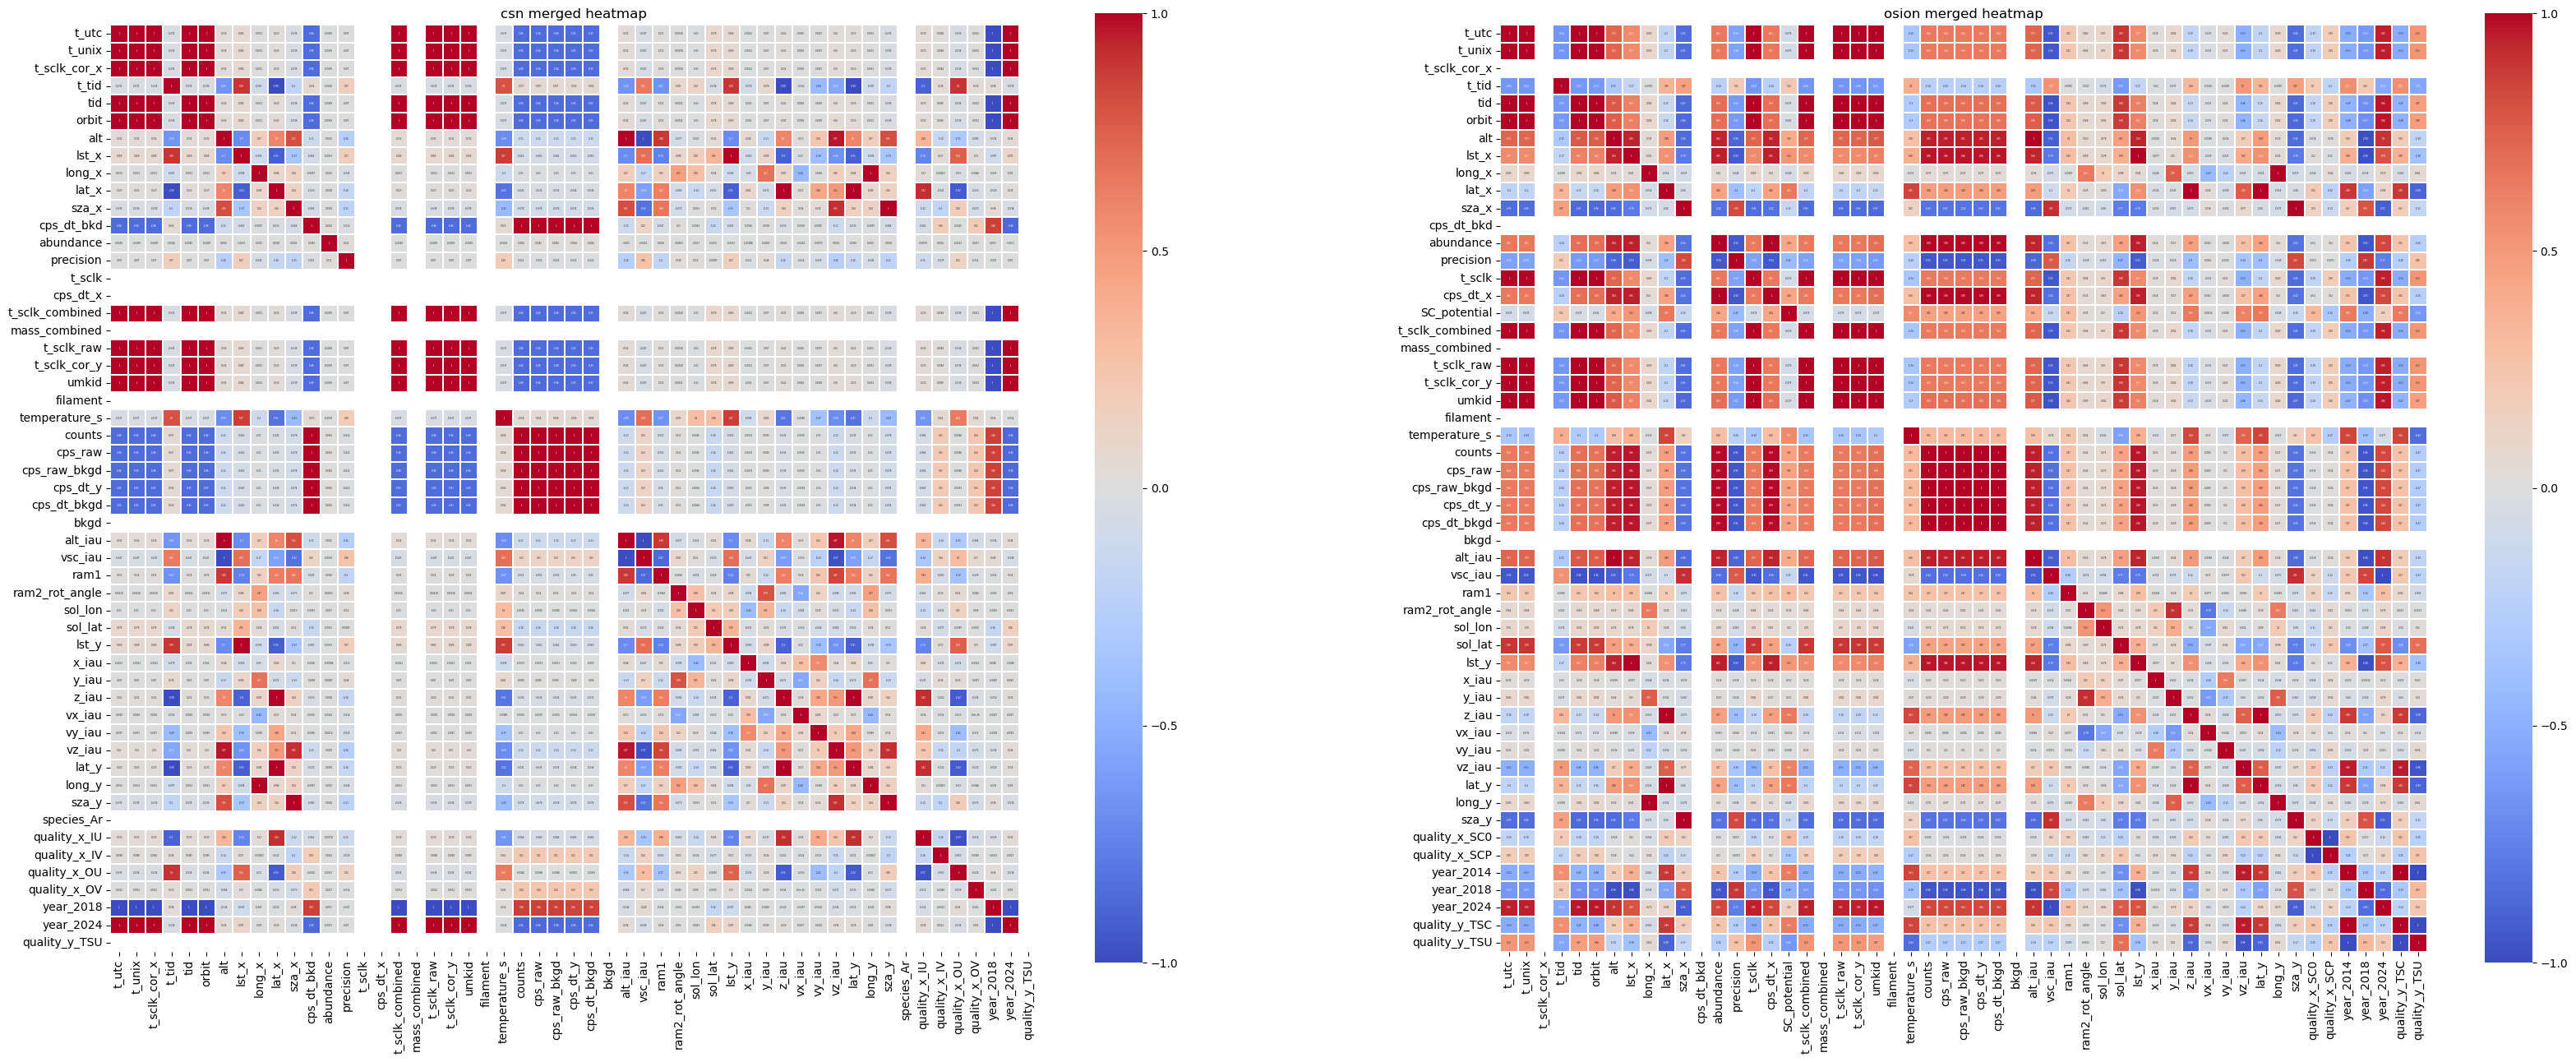

In [50]:
# Create dataframes for correlation matrices, dropping problematic features (constant, redundant, no correlations, etc.)
merged_osion_nums = pd.get_dummies(merged_df[merged_df['focusmode'] == 'osion'].drop(['focusmode', 'multiplier', 'sensitivity',
                                                                                      'mass', 'ion_mass', 'species'], axis=1))
merged_csn_nums = pd.get_dummies(merged_df[merged_df['focusmode'] == 'csn'].drop(['focusmode', 'multiplier', 'sensitivity',
                                                                                  'mass', 'ion_mass', 'SC_potential'], axis=1))

df_corrs = [merged_csn_nums, merged_osion_nums]
titles = ['csn merged heatmap', 'osion merged heatmap']

fig, axs = plt.subplots(1, 2, figsize=(40,30))

for i in range(2):
    sns.heatmap(df_corrs[i].corr(),
        ax = axs[i],
        square = True,
        linewidths = .3,
        cmap = 'coolwarm',
        cbar_kws = {'shrink': .5, 
                    'ticks' : [-1, -.5, 0, 0.5, 1]},
        vmin = -1, 
        vmax = 1,
        annot = True,
        annot_kws = {"size": 100 / len(df_corrs[i].columns)})
    axs[i].set_title(titles[i])

plt.savefig("NGIMS_merged_heatmaps.png")

#### Heatmap Summary
There's a lot of features to unpack here and way too many correlation numbers to read, so let's
take some more general observations and unpack them.
- **redundant variables:** individual levels already have redundant variables, so with the two levels
  merged we can now see full groups of them. These include all of the many time variables, as well
  as mass counts for variace levels of calibration. The one important note here is that **we do not
  see any substantial change in counts for different levels of calibration**, with all of cps features
  and abundance getting a correlation of 1. (On the heatmap, these can be observed as the dark red
  stripes and squares in the center rows/columns).
- **categorical variables:** some of the dummy variables created to include categories can be seen near
  the bottom of the heatmap. Looking at the 'year' variables, we can once again see which features we
  found to be associated with a certain month/year in the above analysis. The other categorical
  variables generally have weak correlations, with the exception of 'quality_TSC' and 'quality_TSU'
  which have one with time/year.
- **extra information:** the level 1b data has a lot of extra features over the level 2 data. Most of
  these are just less processed information which isn't very interesting, like the geodetic IAU
  coordinates and angles for the MAVEN APP. The one exception would possibly be spacecraft temperature
  ('temperature_s') which might be an interesting feature to consider.

Overall, we can see that the two levels do really hold the same information, with level 1b also
containing some extra (but ultimately not very relevant) information.

### TID 14015 Heatmaps
Our next try at comparing the levels is to create two separate heatmaps for the same experiment.
Since merging proved to be a messy process and the results were a little tricky to interpret, we
instead try to see if we can observe the same trends in both data levels between experiments. In
this case, we choose test id 14015. We also choose to focus on the csn data since it seems to
line up better.

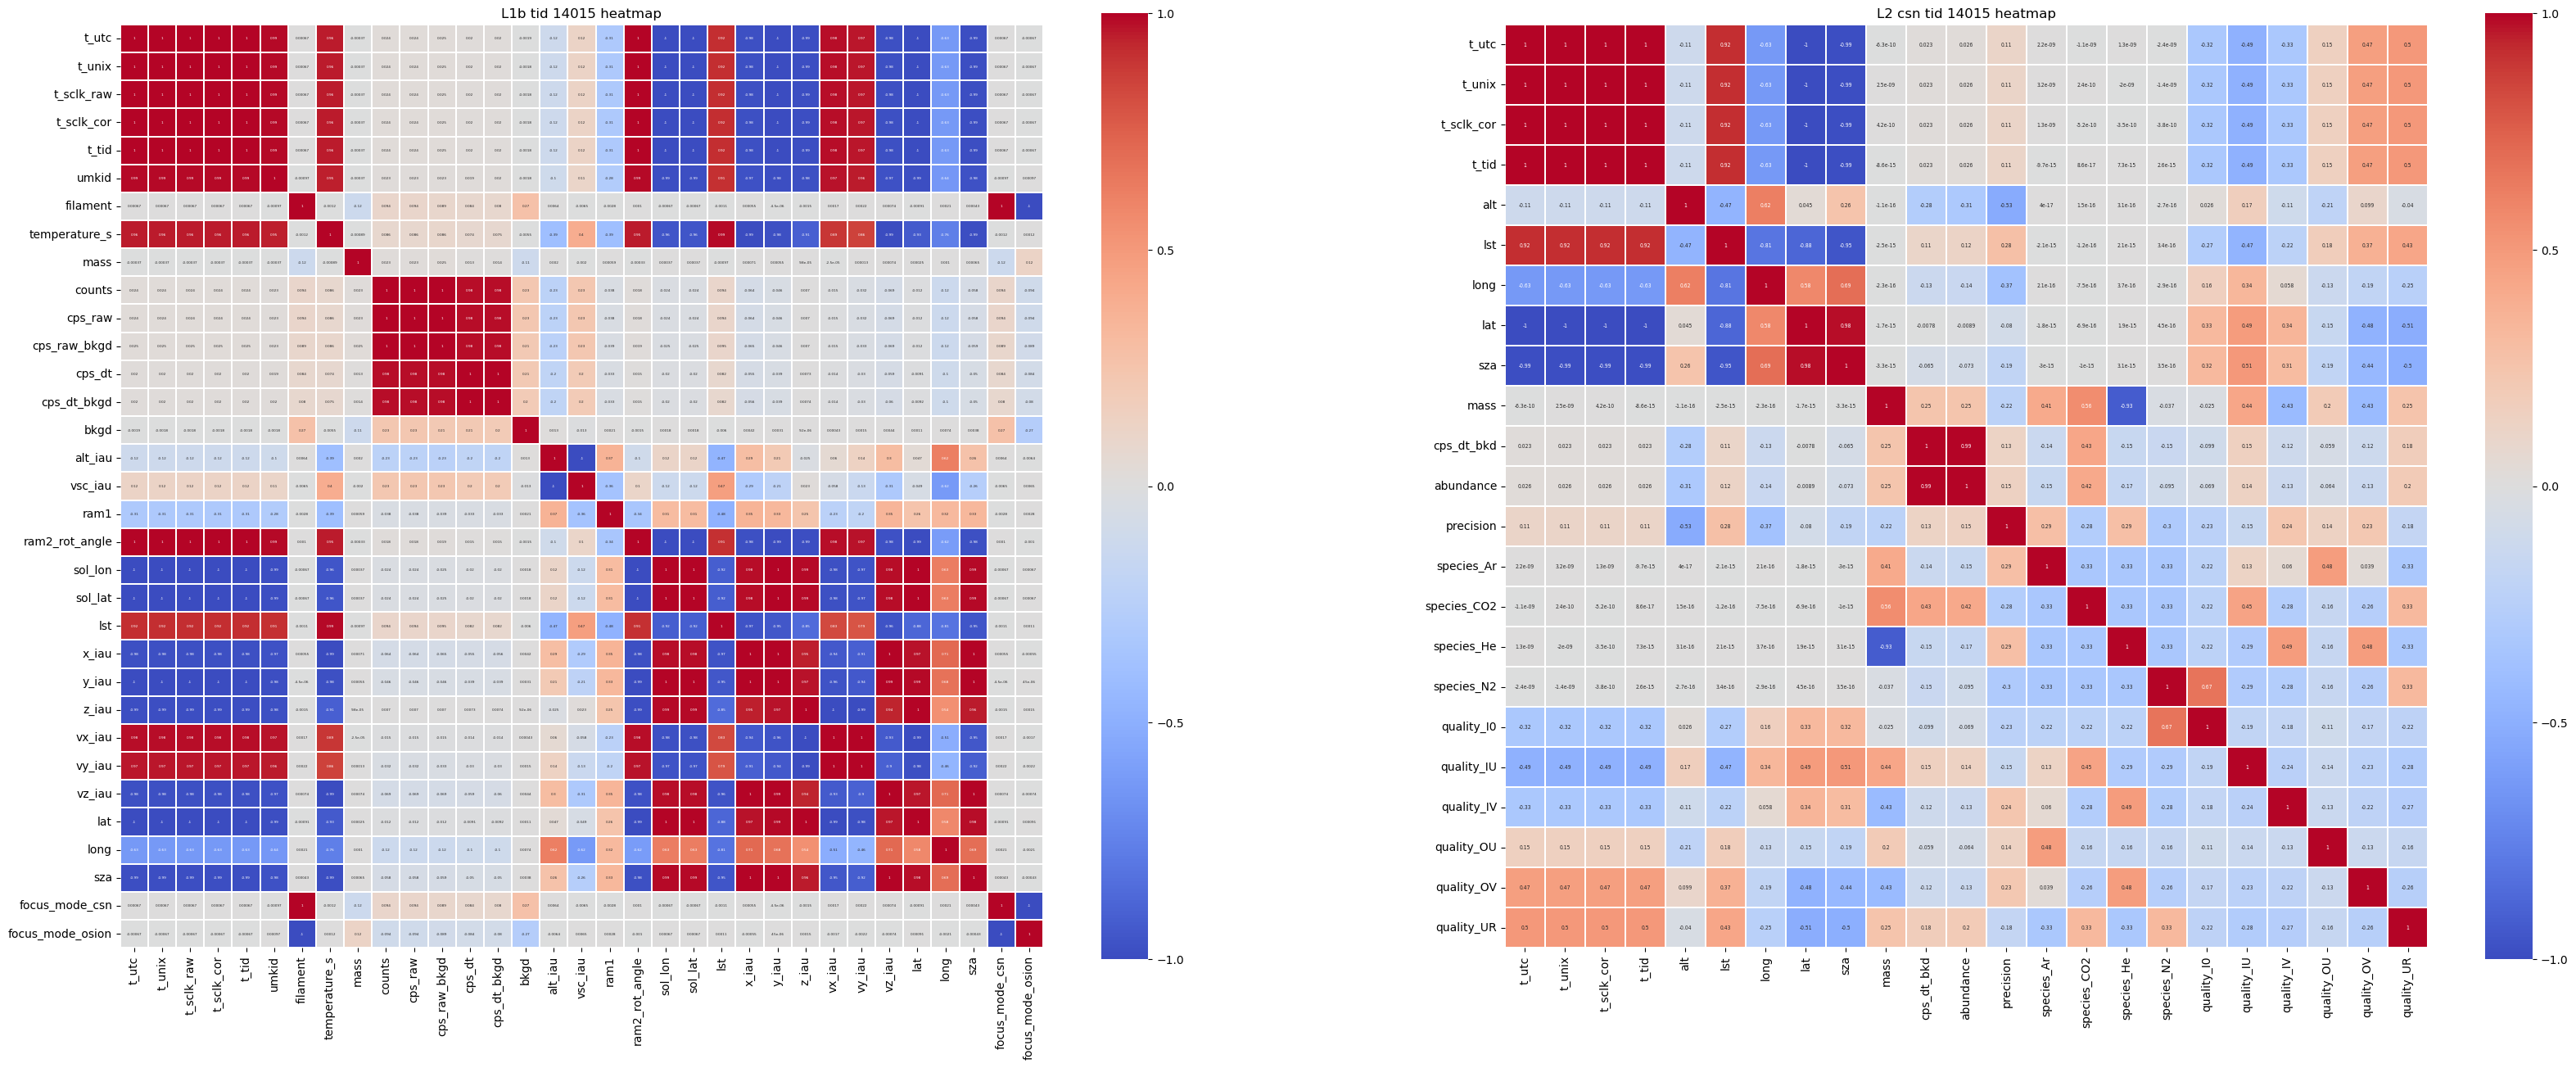

In [51]:
# Create dataframes, filtering for specific tid and dropping unimportant features
tid14015_L2 = L2_csn_df_nums[L2_csn_df_nums['tid'] == 14015].drop(['tid', 'orbit', 'year_2014', 'year_2018', 'year_2024',
                                                                   'species_CO', 'species_O'], axis=1)
tid14015_L1b = L1b_df_nums[L1b_df_nums['tid'] == 14015].drop(['tid', 'orbit', 'year_2014', 'year_2018', 'year_2024', 
                                                              'quality_TSC', 'quality_TSU'], axis=1)

df_corrs = [tid14015_L1b, tid14015_L2]
titles = ['L1b tid 14015 heatmap', 'L2 csn tid 14015 heatmap']

fig, axs = plt.subplots(1, 2, figsize=(40,30))

for i in range(2):
    sns.heatmap(df_corrs[i].corr(),
        ax = axs[i],
        square = True,
        linewidths = .3,
        cmap = 'coolwarm',
        cbar_kws = {'shrink': .5, 
                    'ticks' : [-1, -.5, 0, 0.5, 1]},
        vmin = -1, 
        vmax = 1,
        annot = True,
        annot_kws = {"size": 100 / len(df_corrs[i].columns)})
    axs[i].set_title(titles[i])

plt.savefig("NGIMS_tid14015_heatmaps.png")

#### Heatmap Summary
Many of the positional and categorical variables that make up the bottom half of each heatmap have little
to nothign to do with each other, but we can take a look at the ones in common. We see similar correlations
with altitude, latitude, longitude, and solar zenith angle. This makese sense as this is the same experiment
for the same orbit of MAVEN. We also see the negative correlation with altitude and cps/abundance. Overall,
everything looks consistent.

### Mass and Count Comparison
For our final comparison, we want to focus on the two most important features: 
<code><span style='color:#BA2220;'>'mass'</span></code> and <code><span style='color:#BA2220;'>'abundance'</span></code>. 
To do this, we will once again choose an experiment for the comparison, this time tid 14020. As mentioned
above, it is hard to find entries from each dataset that exactly match. To get around this, we will plot
abundance vs time for specific masses, allowing us to see the shape even if the exact data points don't
match up.

#### Creating Merged Dataframe
We first create a dataframe filtered to tid 14020 for both the level 1b and level 2 data, and then
choose a subset of features we want. We then rename the columns to match and add a 'level' label
so that we can distinguish them. We can then use <code>pd.<span style='color:#0055AA;'>concat</span>()</code>
to combine them into one dataframe.

*Note: We include both* <code><span style='color:#BA2220;'>'cps_raw'</span></code> *and*
<code><span style='color:#BA2220;'>'cps'</span></code> *when plotting the level 1b data.
The former is not calibrated for instrument background or deadtime correction, which can lead to
different counts. This is to see if we can see anything more "messy" for the raw counts. Based
on the values from the heatmaps earlier this appears to be marginal overall, but for high
high dabundance species deadtime is likely more substantial.*

In [ ]:
# Get level 1b from tid 14020
L1b_tid14020_df = L1b_df[L1b_df['tid'] == 14020]

# Create dataframe for raw counts and prepare for concatenation
L1b_raw_tid14020_df = L1b_tid14020_df.loc[:, ['t_unix', 't_tid', 'mass_combined', 'cps_raw', 'focusmode']]
L1b_raw_tid14020_df['level'] = '1b_raw'
L1b_raw_tid14020_df.rename(columns={'mass_combined': 'mass', 'cps_raw': 'cps'}, inplace=True)

# Create dataframe for calibrated counts and prepare for concatenation
L1b_cal_tid14020_df = L1b_tid14020_df.loc[:, ['t_unix', 't_tid', 'mass_combined', 'cps_dt_bkgd', 'focusmode']]
L1b_cal_tid14020_df['level'] = '1b_calibrated'
L1b_cal_tid14020_df.rename(columns={'mass_combined': 'mass', 'cps_dt_bkgd': 'cps'}, inplace=True)

# Grab level 2 data from tid 14020 and prepare for concatenation
L2_tid14020_df = L2_df[L2_df['tid'] == 14020]
L2_tid14020_df['mass'] = L2_tid14020_df['mass'].fillna(0) + L2_tid14020_df['ion_mass'].fillna(0)
L2_tid14020_df['cps'] = L2_tid14020_df['cps_dt_bkd'].fillna(0) + L2_tid14020_df['cps_dt'].fillna(0)
L2_tid14020_df = L2_tid14020_df.loc[:, ['t_unix', 't_tid', 'mass', 'cps', 'focusmode']]
L2_tid14020_df['level'] = '2'

# Create final merged dataframe
mass14020_df = pd.concat([L1b_raw_tid14020_df, L1b_cal_tid14020_df, L2_tid14020_df])
mass14020_df.info()
mass14020_df.head()

##### Merged Dataframe Summary
Between level 1b raw/calibrated and level 2, we have over 100,000 data points from over 50,000
distinct entries. We are looking to see how the counts differ between the raw and calibrated
data and then whthere or not the counts match up between levels (and if not explain any
discrepancies). As before, we make sure to use log scale for the abundance values so that the 
data is easier to interpret.

### Cps vs Time for Mass 44 (CO2)
We first start with CO2, since it is by far the most abundant specimen in Mars' atmosphere. We
have all the counts on the same plot colored by calibration and level.

In [726]:
massCO2_data = mass14020_df[mass14020_df['mass'] == 44]
fig = px.scatter(
    massCO2_data, 
    x='t_tid', 
    y='cps',
    log_y=True,
    color='level', 
    color_discrete_sequence=px.colors.qualitative.Plotly,
    hover_data=mass14020_df.columns.values,
    title='tid 14020 10/14 CO2 cps vs time by level and calibration')

fig.write_html('cps_vs_time_by_level_cal_CO2.html')

#### Summary
There is actually a lot to explore in this plot! 
- We can see two distinct bands at considerably different abundance levels. Looking closely at the hover
  data, we can see this is due to mass 44 being recorded for both focus modes, but at substantially lower
  abundance for osion.
- For the level 1b data, the calibrated counts are lower than the raw counts for low counts and higher
  for high counts. This can probably be explained by background being more significant at lower counts,
  inflating observed values, while at high counts deadtime correction is the bigger factor. In this case,
  there is definitely a significant difference bewteen the raw and calibrated counts.
- The level 2 and level 1b counts match well up to a certain count threshold, at which point they diverge
  as the level 1b counts plummet and entirely miss the peak. This is somewhat confusing, because the best
  explanation for this is that the level 2 data is dead time corrected and the level 1b data is not. At
  the very high counts, the detector can't register the particles fast enough and eventually picks them up
  as one contnuous signal, missing the peak entirely. However, in the NGIMS documentation, under
  "**Generation of Level 1B**", it says the following:
  *"The raw ASCII detector count rates are corrected for detector resonse (dead time correction)...Instrument
  background for the processed mass channel are subtracted."*
  The only reasonable explanation is that some additional correction must be applied between level 1b and level 2.

### Cps vs Time for High Density Species
Now that we have compared some results for CO2, it is worth investigating some other masses with high
counts. To do this, we create a label for each mass and its cps level, and then plot some of the
highest count species coloring by this label.

In [761]:
mass14020_df['label'] = 'level_' + mass14020_df['level'].str.cat(mass14020_df['mass'].astype(str), sep='_mass_')
mass14020_df['label'].unique()[:10]

array(['level_1b_raw_mass_2.0', 'level_1b_raw_mass_3.0',
       'level_1b_raw_mass_4.0', 'level_1b_raw_mass_8.0',
       'level_1b_raw_mass_12.0', 'level_1b_raw_mass_13.0',
       'level_1b_raw_mass_14.0', 'level_1b_raw_mass_14.5',
       'level_1b_raw_mass_15.0', 'level_1b_raw_mass_316.0'], dtype=object)

In [756]:
# Grab the data for the five highest count masses
mass_data = mass14020_df[mass14020_df['mass'].isin(mass14020_df.groupby('mass')['cps'].mean().sort_values(ascending=False).head(5).index)]
fig = px.scatter(
    mass_data, 
    x='t_tid', 
    y='cps',
    log_y=True,
    color='label', 
    color_discrete_sequence=px.colors.qualitative.Light24,
    hover_data=mass14020_df.columns.values,
    title='tid 14020 10/14 cps vs time by level_cal')

fig.write_html('cps_vs_time_by_level_cal.html')

#### Summary
With some other masses to look at, we finally have enough data to draw some conclusions about the two levels.
- **similar plots between masses:** for any selected mass, we see the same basic structure seen in CO2, with
  two distinct bands for each focus mode and raw data that first overestimates and then underestimates count
  at high values for the level 1b data.
- **extra m/z values:** we see some very high "mass" numbers at just the level 1b data: mass 332 and mass 194.
  This seems confusing because NGIMS only measures masses up to 150 and they don't appear at the level 2 data.
  However, this can be explained by the level 1b data having units of m/z (mass per charge) while the level 2
  data is just in mass (amu). If we compare the plots of mass 332 and mass 194, they match up fairly well with
  mass 32 and mass 40 respectively.
- **missing peaks:** In the other included masses, we see that all the other included masses have a fully intact
  peak for the level 1b data, barring some small variance from calibration. This gives evidence that this
  discrepancy is indeed related to the very high CO2 counts. Looking closely at the mass 44 data, we can see that
  this dropoff begins at a count value range of 30-40 million. Checking the NGIMS documentation, we find a very
  compelling reason for this under **3.7.1 (Characterization of the Detector Chain):**
  
  *"The linearity of each detector chain was established using He, Ne, Ar, and Kr for densities that range from
  $10^5$ to $10^{10}$ atoms/cc...the data shows that both detector chains exhibit good linearity up to $2\times10^6$
  c/s above which they display a non-linear behavior common to all paralyzable counting systems...by applying
  this dead time correction, the linearity of of both detection chains can be extended up to $10^7$ c/s after
  processing."*
  
  Revisiting the data, we can see that this description matches extremely well.
  1. Shortly after 2 million cps is when we see the calibrated counts overtake the raw counts for the level 1b
     data. Since the dead time correction does not apply until 2 million, this make sense as the background
     correction (which lowers calibrated counts) would have been the dominant correction up to this point.
  2. For the CO2 data, we can see that the level 1b counts drop off from the level 2 counts as soon as 30
     million cps, and actually start to diverge a little earlier (visible shortly before 20 million).
     The dead time correction extension stopping past 10 million is therefore consistent with the data. With
     this in mind, **the best explanation is that there is an additional correction applied to the level 2
     data for counts surpassing the dead time correction extension.** In the "Generation of Level 2"
     section in **3.8 (NGIMS Data Products)**, while there is mention of categorizing the counts and
     calculating abundance, there is no mention of this correction. However, it still appears as the most
     logical conclusion.

### Level Comparison Conclusion
With our investigation of level 1b and level 2 features (especially mass and cps/abundance) completed, we
can draw our conclusion about the two levels.
- **general features:** while level 1b has many extra features compared to level 2, almost all of them store
  the same information (just in a less processed form). The one exception that could be argued is spacecraft
  temperature, as it appears to have changed and is not present in the level 2 data.
- **mass and counts:** the level 2 data has at least one additional correction applied and better
  categorization of the masses, making it more suitable for science.

While this would be expected of higher level data, we have verified that the two levels are the same and we
are not losing any significant information (just gaining additional calibrations). For the next set of
analyses, we will stick with the level 2 data.


# Part 2: 2017 Data Analysis and Dimensionality Reduction
Now that we have finished our comparison of of the NGIMS data for different time periods and calibration
levels, we move on to Part 2! One of the difficulties encountered in Part 1 trying to compare the three
chosen months was that the limited data and different experiment formats made them hard to compare (the
prime example being the high altitude experiments from January 2024). Also, the three discete clusters
formed by time made dimensionality reduction difficult, even with time variables removed. As a result,
in this section we focus on one full year of data with the hope that a greater pool of experiments and
a more local and continuous time period will allow us to better unpack the data, with 2017 being
our year of choice. This is broken into two steps:
1. Perform some of the EDA techniques used in the first section, using a heatmap and pairplots to
   get an overview of the data and then more specific scatterplots if necessary.
2. Use various dimensionality reduction techniques to analyze the data, tweaking the input and
   ultimately comparing their efficacy with respect to clustering the data.

## 2017 Data EDA
We start with similar EDA from Part 1. Our goal is to compare what we see with the results from the
same analyses for the merged data for several different time periods. It is possible we can see
clearer trends since there is less variance with time.

### Loading and Processing Data
Once again, we start by loading in the 2017 data. This time, however, we include the full year instead
of a select month.

In [52]:
# Load data from the specified 'tar.gz' file into dataframe
os.chdir(dataDir)
data_filename = 'ngims_derivedL2_2017.tar.gz'

L2_2017_df = None

with tarfile.open(data_filename, "r:*") as tar:
    csv_paths = list(n for n in tar.getnames() if isValidFile(n))
    for path in csv_paths:
        data = pd.read_csv(tar.extractfile(path))
        L2_2017_df = pd.concat([L2_2017_df, data], axis=0, ignore_index=True)


os.chdir(plotsDir)

L2_2017_df.info()
L2_2017_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17336524 entries, 0 to 17336523
Data columns (total 23 columns):
 #   Column        Dtype  
---  ------        -----  
 0   t_utc         object 
 1   t_unix        float64
 2   t_sclk_cor    float64
 3   t_tid         float64
 4   tid           int64  
 5   orbit         int64  
 6   focusmode     object 
 7   alt           float64
 8   lst           float64
 9   long          float64
 10  lat           float64
 11  sza           float64
 12  mass          float64
 13  species       object 
 14  cps_dt_bkd    float64
 15  abundance     float64
 16  precision     float64
 17  quality       object 
 18  t_sclk        float64
 19  ion_mass      float64
 20  cps_dt        float64
 21  sensitivity   float64
 22  SC_potential  float64
dtypes: float64(17), int64(2), object(4)
memory usage: 3.0+ GB


t_utc        t_unix    t_sclk_cor       t_tid    tid  orbit  \
0  2017-11-30T07:24:26  1.512027e+09  5.652986e+08  4734.44486  25816   6158   
1  2017-11-30T07:24:28  1.512027e+09  5.652986e+08  4736.44486  25816   6158   
2  2017-11-30T07:24:30  1.512027e+09  5.652986e+08  4738.44486  25816   6158   
3  2017-11-30T07:24:32  1.512027e+09  5.652986e+08  4740.44486  25816   6158   
4  2017-11-30T07:24:34  1.512027e+09  5.652986e+08  4742.44486  25816   6158   

  focusmode       alt       lst      long  ...  species  cps_dt_bkd  \
0       csn  483.0072  8.672778 -7.673005  ...       Ar         0.0   
1       csn  481.2197  8.678611 -7.595913  ...       Ar         0.0   
2       csn  479.4359  8.684167 -7.519142  ...       Ar         0.0   
3       csn  477.6558  8.690000 -7.442690  ...       Ar         0.0   
4       csn  475.8794  8.695556 -7.366557  ...       Ar         0.0   

   abundance precision  quality  t_sclk  ion_mass cps_dt  sensitivity  \
0        0.0       0.0       IU     NaN       NaN    NaN          NaN   
1        0.0       0.0       IU     NaN       NaN    NaN          NaN   
2        0.0       0.0       IU     NaN       NaN    NaN          NaN   
3        0.0       0.0       IU     NaN       NaN    NaN          NaN   
4        0.0       0.0       IU     NaN       NaN    NaN          NaN   

   SC_potential  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  

[5 rows x 23 columns]

#### Dataframe Modification
We can see that we have over 17 million observations for the 2017 level 2 data. You may notice that
many of the features appear as null for our entries. This is again due to combining data from both
focus modes. As a result, we make new features <code><span style='color:#BA2220;'>'mass'</span></code>
and <code><span style='color:#BA2220;'>'cps'</span></code> to combine the differently named features
for each focus mode. Then, we remove the infinite counts that we noted for the Part 1 data. Also, as
the CO measurements are somewhat untrustworthy*, they are dropped as well. Finally, we drop the
features that are distinct to each focus mode, as we would like to keep all the data together and
these will make it difficult.

*Note: Thank you to Shane Stone for this information! Further analysis and expertise would likely
be needed to motivate this, so I am leaving it for now as beyond the scope of this notebook. (CO
corresponds to mass 28).*

In [53]:
# Create new 'mass' and 'cps' features merging mass and count features for csn/osion
L2_2017_df['mass'] = L2_2017_df['mass'].fillna(0) + L2_2017_df['ion_mass'].fillna(0)
L2_2017_df['cps'] = L2_2017_df['cps_dt_bkd'].fillna(0) + L2_2017_df['cps_dt'].fillna(0)

# Drop infinite abundance counts, CO observations from csn, and focus mode specific features
L2_2017_dfm = L2_2017_df[(L2_2017_df['species'].fillna(0) != 'CO') 
                        & (L2_2017_df['abundance'] != np.inf) 
                        & (L2_2017_df['cps'] != np.inf)].drop(
    ['t_sclk_cor', 't_sclk', 'ion_mass', 'species', 'cps_dt_bkd', 'cps_dt', 'quality', 'SC_potential', 'sensitivity'], axis=1)

L2_2017_dfm.info()
L2_2017_dfm.head()

<class 'pandas.core.frame.DataFrame'>
Index: 16212771 entries, 0 to 17336523
Data columns (total 15 columns):
 #   Column     Dtype  
---  ------     -----  
 0   t_utc      object 
 1   t_unix     float64
 2   t_tid      float64
 3   tid        int64  
 4   orbit      int64  
 5   focusmode  object 
 6   alt        float64
 7   lst        float64
 8   long       float64
 9   lat        float64
 10  sza        float64
 11  mass       float64
 12  abundance  float64
 13  precision  float64
 14  cps        float64
dtypes: float64(11), int64(2), object(2)
memory usage: 1.9+ GB


t_utc        t_unix       t_tid    tid  orbit focusmode  \
0  2017-11-30T07:24:26  1.512027e+09  4734.44486  25816   6158       csn   
1  2017-11-30T07:24:28  1.512027e+09  4736.44486  25816   6158       csn   
2  2017-11-30T07:24:30  1.512027e+09  4738.44486  25816   6158       csn   
3  2017-11-30T07:24:32  1.512027e+09  4740.44486  25816   6158       csn   
4  2017-11-30T07:24:34  1.512027e+09  4742.44486  25816   6158       csn   

        alt       lst      long       lat       sza  mass  abundance  \
0  483.0072  8.672778 -7.673005 -53.28848  89.74986  40.0        0.0   
1  481.2197  8.678611 -7.595913 -53.18739  89.64059  40.0        0.0   
2  479.4359  8.684167 -7.519142 -53.08614  89.53281  40.0        0.0   
3  477.6558  8.690000 -7.442690 -52.98473  89.42306  40.0        0.0   
4  475.8794  8.695556 -7.366557 -52.88317  89.31481  40.0        0.0   

   precision  cps  
0        0.0  0.0  
1        0.0  0.0  
2        0.0  0.0  
3        0.0  0.0  
4        0.0  0.0

### Heatmap
After processing, we still have over 16 million entries that meet all of our criteria! Before
diving into any more detailed plots, we first make a heatmap and pairplots as we did in Part 1,
starting with the heatmap. We modify the dataframe, generate the correlation matrix and create
the plot.

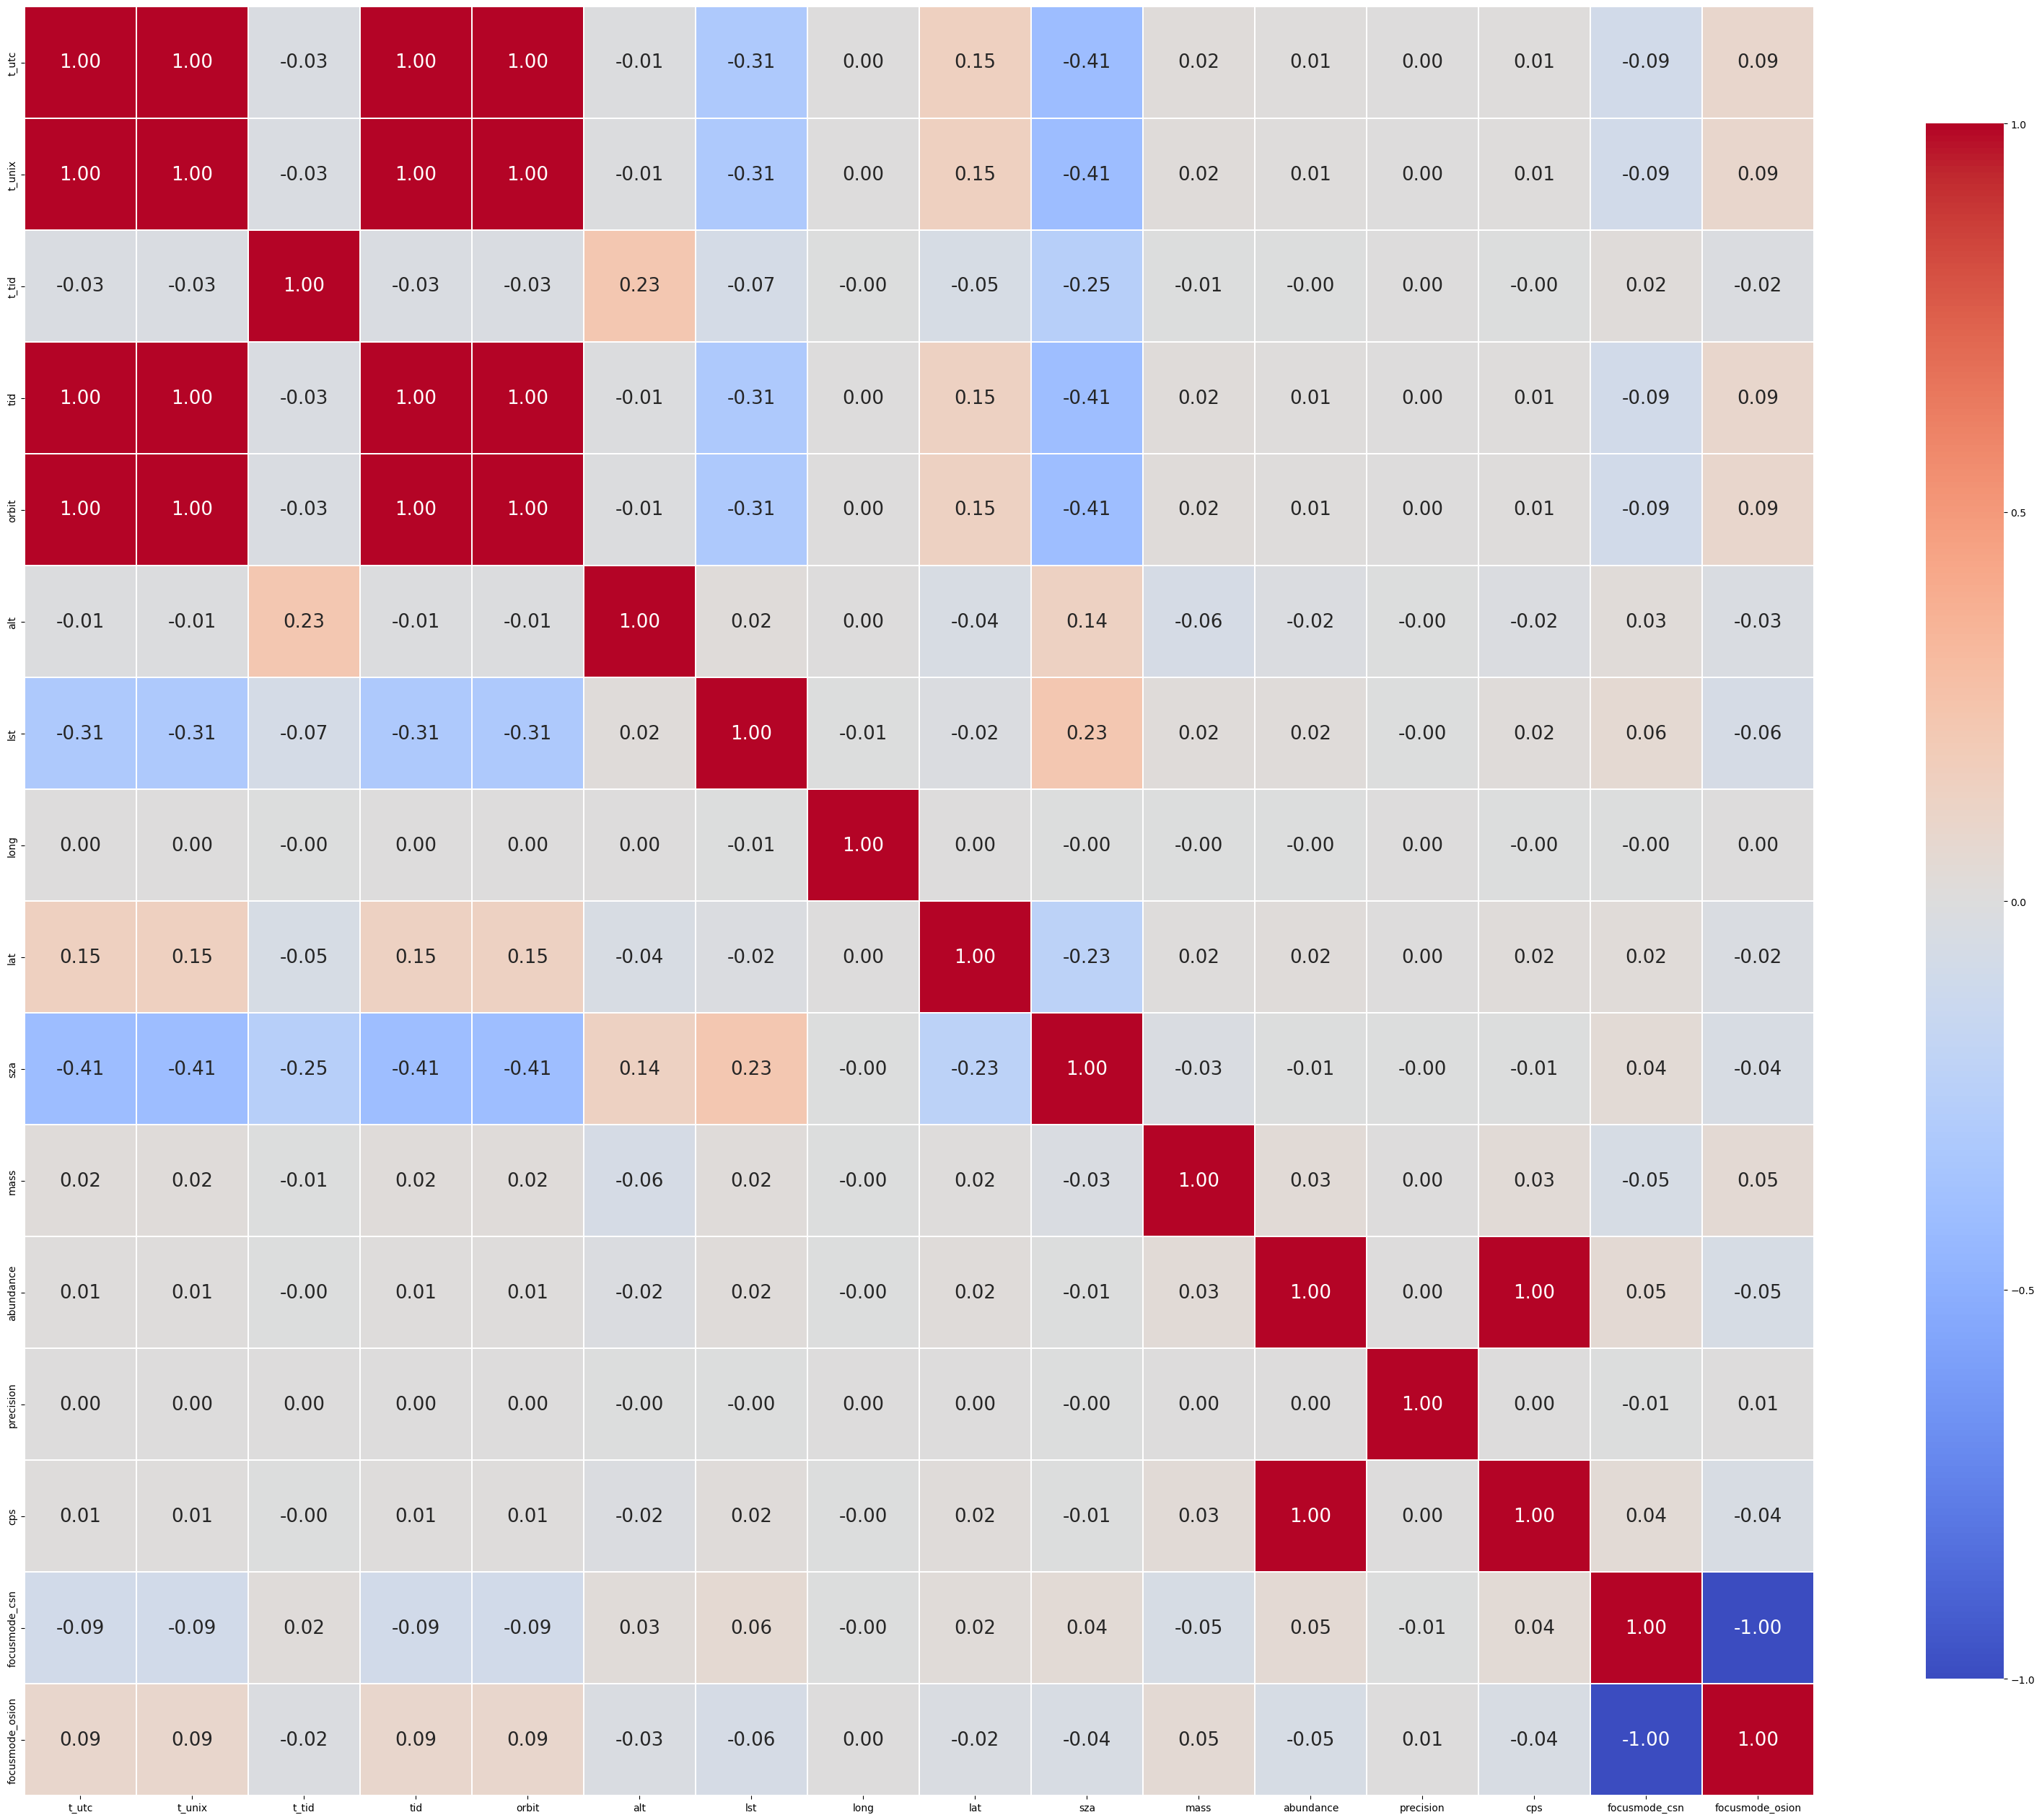

In [54]:
# Convert 't_utc' to workable datetime object, then get dummies for the categorical variables
L2_2017_dfm['t_utc'] = pd.to_datetime(L2_2017_dfm['t_utc'])
L2_2017_dfm_nums = pd.get_dummies(L2_2017_dfm)

# Generate heatmap
fig = plt.figure(figsize=(40,40))
sns.heatmap(
    L2_2017_dfm_nums.corr(),
    square = True,
    linewidths = .3,
    cmap = 'coolwarm',
    cbar_kws = {'shrink': .7, 
                'ticks' : [-1, -.5, 0, 0.5, 1]},
    vmin = -1, 
    vmax = 1,
    annot = True,
    annot_kws = {"size": 300 / len(L2_2017_dfm_nums.columns)},
    fmt='.2f')

plt.savefig("2017_heatmap.png")

#### Heatmap Summary
We see a very similar heatmap to the one produced in Part 1, with fairly low correlation overall.
Once again, we can see that MAVEN's orbit has given several variables a strong correlation with time,
including <code><span style='color:#BA2220;'>'lst'</span></code>, <code><span style='color:#BA2220;'>'lat'</span></code>
and <code><span style='color:#BA2220;'>'sza'</span></code>. This behavior has already been explained
from Part 1, although as one interesting note we can see that <code><span style='color:#BA2220;'>'lst'</span></code>
has a negative correlation with time for this data as oppose to a positive one from Part 1, due to
a different phase in its period.

### Pairplots
Now, we can generate our pairplots! Since there is a massive amount of data, we first create our
sample dataframe of 100,000 samples. Our three most interesting variables are
<code><span style='color:#BA2220;'>'mass'</span></code>,
<code><span style='color:#BA2220;'>'alt'</span></code>, and
<code><span style='color:#BA2220;'>'abundance'</span></code>, 
so we make sure to include them. However, as we saw in our exploration of cps/abundance in Part 1,
it is more suitable to use log scale for abundance, so we create a new feature
<code><span style='color:#BA2220;'>'log_abundance'</span></code>
to use for our pairplots. We also include
<code><span style='color:#BA2220;'>'t_unix'</span></code>,
which was not an option in Part 1 since our data came from three very different times and
therefore was not suitable for plotting with time as a variable. Finally, we use
<code><span style='color:#BA2220;'>'focusmode'</span></code>
as the color so that we can look for any differences bewteen the two modes, like we saw
with the January 2024 csn experiments.

<Figure size 4000x4000 with 0 Axes>

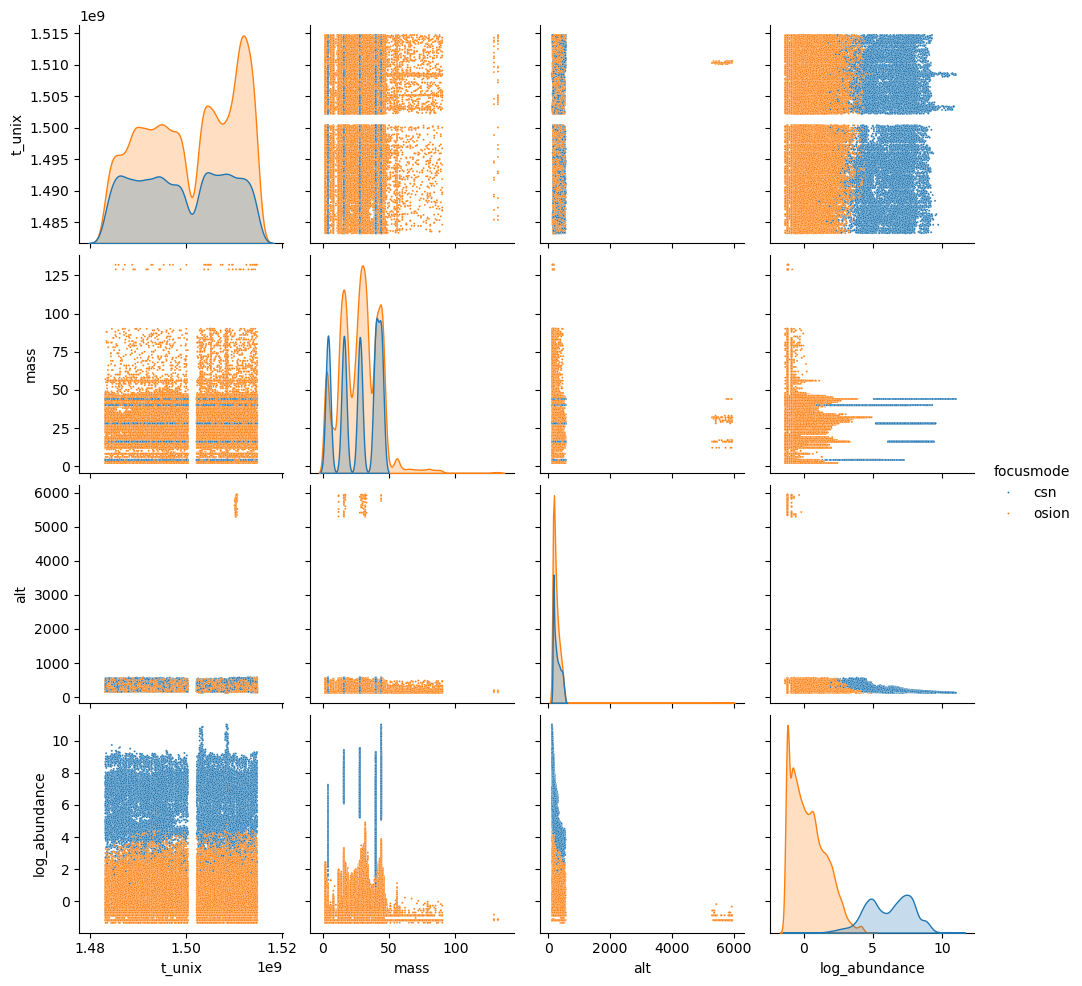

In [807]:
# Get sample data
sample2017 = L2_2017_dfm.sample(100000, random_state=2522350).reset_index(drop=True)
sample2017['log_abundance'] = np.log10(sample2017['abundance'].values)

# Generate pairplots
plt.figure(figsize=(40,40))
sns.pairplot(sample2017, 
             vars=["t_unix", "mass", "alt", "log_abundance"], 
             hue='focusmode',
             palette=sns.color_palette("tab10"),
             diag_kind='kde', 
             plot_kws={"s": 2})
plt.savefig("L2_2017_pairplots.png")

#### Pairplots Summary
With time included, we can see some new plots that weren't really available in Part 1. We also see some
new things not observed in the original dataset. Here's a brief summary of each plot:
1. KDE plots:
   - <code><span style='color:#BA2220;'>'t_unix'</span></code>:
     there are actually a couple interesting things to note here. We see a brief period of time
     where no measurements were taken, and also some times where more observations were recorded.
   - <code><span style='color:#BA2220;'>'mass'</span></code>:
     we can see four major peaks for masses that were recorded more than others; these likely
     correspond to our four most abundant masses (16, 32, 40, 44) now that we have dropped CO data.
   - <code><span style='color:#BA2220;'>'alt'</span></code>:
     there are a few observations at much higher altitude (5000+ km!) compared to the rest of the
     data. These are measurements taken at the **apoapsis** of the orbit to check up on instrument health.
   - <code><span style='color:#BA2220;'>'log_abundance'</span></code>:
     with the log scale, we can compare the two focus modes a lot better! We see that csn gets much
     higher abundance readings than osion, while osion has a lot of entries at very low abundance.
2. Pairplots:
   - <code><span style='color:#BA2220;'>'alt'</span></code> vs <code><span style='color:#BA2220;'>'mass'</span></code>:
     ignoring the apoapsis measurements, we see similar trends to the Part 1 data, with a fairly
     even distribution and then a couple heavier masses only found at low altitudes.
   - <code><span style='color:#BA2220;'>'log_abundance'</span></code> vs <code><span style='color:#BA2220;'>'t_unix'</span></code>:
     this plot is mostly uninteresting, but we see a couple of large peaks for abundance in the
     csn data for two different dates. It would be interesting to understand if there was some
     sort of planetary event that caused this.
   - <code><span style='color:#BA2220;'>'log_abundance'</span></code> vs <code><span style='color:#BA2220;'>'mass'</span></code>:
     we can see a few distinct peaks for species with higher abundace. These match up well
     with the peaks in the mass KDE plot (they are not the same so worth noting).
   - <code><span style='color:#BA2220;'>'log_abundance'</span></code> vs <code><span style='color:#BA2220;'>'alt'</span></code>:
     once again ignoring the apoapsis measurements, we can see a nice trend with abundance
     decreasing with altitude.

*Note: I have excluded the other time pairplots from the analysis because they are uninteresting.*

### Additional Scatterplots
The heatmap and pairplots have already given us a great overview of the data, but we also
include a few more specific plots to further explore some of the above observations.

#### Time-correlated Features
We have always noted that <code><span style='color:#BA2220;'>'lst'</span></code> and
<code><span style='color:#BA2220;'>'sza'</span></code> have a strong correlation with
time, which changes based on the dataset. Since we now have a full year of data to
work with, we make some final plots to get a better sense of their periodization. We
define one more function to help us and then plot both features against time.

In [ ]:
def L2_ScatterBy(DataFrame, feature1, feature2, by=None):
    """Create scatterplot of two variables in dataset, coloring by an optional third variable.
    
    Arguments:
    DataFrame -- pandas dataframe with relevant data
    feature1 -- column name in dataframe with feature to plot on x-axis
    feature2 -- column name in dataframe with feature to plot on y-axis

    Keyword Arguments:
    by -- column name in dataframe with feature to use as color (default None)
    """
    fig = px.scatter(
        DataFrame,
        x=feature1,
        y=feature2,
        color=by,
        hover_data=['t_utc', 'tid', 'alt', 'mass', 'abundance'],
        title=f'{feature1} vs {feature2}, color={by}')

    if PLOTLY_DISPLAY == True:
        fig.show()

    fig.write_html(f'{feature1}_vs_{feature2}_color{by}.html')
    
L2_ScatterBy(sample2017, 't_utc', 'lst')
L2_ScatterBy(sample2017, 't_utc', 'sza')

##### Summary
With data from a full year, we can clearly see these change predictably with MAVEN's orbit.
Note that local solar time loops back around from 24 to 0, resulting in the multiple stripes.

### Abundance vs Time by Mass
Since we found a cps vs time plot useful for a single experiment in Part 1, we repeat this
for abundance, this time including the full year. Once again, we filter for select masses
with the highest abundance so that our plot doesn't get too messy.

In [359]:
# Filter data for high abundance masses
mass_data = sample2017[sample2017['mass'].isin(sample2017.groupby('mass')['abundance'].mean().sort_values(ascending=False).head(10).index)]

# Convert selected masses to strings so they are treated as categorical
mass_data['mass'] = mass_data['mass'].astype(str)

# Plot data
fig = px.scatter(
    mass_data, 
    x='t_utc', 
    y='abundance',
    log_y=True,
    color='mass', 
    color_discrete_sequence=px.colors.qualitative.Plotly,
    hover_data=['t_utc', 'tid', 'alt', 'mass', 'abundance'],
    title='Abundance over time by mass')

if PLOTLY_DISPLAY == True:
    fig.show()

fig.write_html('abundance_vs_time_2017.html')

#### Summary
We already saw this data in the scatterplot, but now we have a little more detail and the
ability to filter by mass. Here are some key observations:
- **high abundance events:** as noted in the pairplots, there are two small time periods
  where we see massive spikes in abundance for the neutral species. We can now see these
  are in August and October 2017. I currently don't have any context for these.
- **other notes:** the abundance levels appear relatively constant throughout the year
  (ignoring the major two events). We can clearly see that CO2 is the dominant species.

### Altitude Adjusted Plots
For our final set of plots, we remove the experiments taken at apoapsis so that we can
see data from the normal altitude range more clearly. Once again, we use
<code><span style='color:#BA2220;'>'log_abundance'</span></code> for clearer plots.

In [821]:
sample2017['alt'].describe()

count    100000.000000
mean        270.835348
std         216.792200
min         121.655100
25%         176.757875
50%         233.662550
75%         333.200025
max        5940.124000
Name: alt, dtype: float64

In [823]:
# Find tids associated with high altitudes
tid_alts = sample2017.groupby('tid')['alt'].mean()
tid_alts = tid_alts[tid_alts > 5000]
tid_alts

tid
25571    5616.925000
25575    5661.840500
25579    5409.925000
25587    5743.266333
25595    5590.330000
25599    5505.456914
25607    5873.361444
25611    5815.274167
25615    5622.543750
25619    5793.426167
25623    5783.156286
25627    5908.735583
25631    5772.552125
25635    5925.311000
25639    5743.809667
Name: alt, dtype: float64

In [825]:
# Filter data by removing selected tids
sample2017m = sample2017[~sample2017['tid'].isin(tid_alts.index)]
sample2017m['alt'].describe()

count    99877.000000
mean       264.128591
std        102.128511
min        121.655100
25%        176.697900
50%        233.460500
75%        332.656000
max        574.456400
Name: alt, dtype: float64

In [827]:
# Produce scatterplots
L2_ScatterBy(sample2017m, 'mass', 'alt', by='log_abundance')
L2_ScatterBy(sample2017m, 'mass', 'log_abundance', by='alt')
L2_ScatterBy(sample2017m, 'alt', 'log_abundance', by='mass')

#### Plot Summary
These plots ultimately contain information that we have already investigated, but it is cool to see
all three key features plotted together! There are a couple observations that this leads to:
1. We can actually see nice grouping by mass in the abundance vs altitude plot. It might be interesting
   to choose the top masses and color by those using a qualitative colormap instead.
2. In the alt versus mass plot, we can now clearly see the neutral species as they have much higher abundance.

### EDA Summary
This concludes our initial EDA for the 2017 data. Overall, we see a lot in common with the merged data
from Part 1 (as expected), but there are definitely a few things we can take away.
- **abnormal experiments:** in Part 1, we saw the a few unusual csn experiments with larger altitude
  ranges, and now in Part 2 we see something similar with the apoapsis measurements. The takeaway here
  is to not let these experiments lead to confusion about the general shape of the data.
- **log scale abundance:** using log scale for all of the abundance plots led to much more insightful
  results. We can now much more clearly see its relationship with mass and altitude.
- **continous time:** with data for a full year, we can see more of an evolution of the data over time
  as opposed to more of a series of snapshots from Part 1. One of the discoveries made with this is
  noticing the two events in 2017 with very large abundance values. There is also the period of time
  with no measurements to investigate.


## Dimensionality Reduction
We conclude our analysis of the 2017 data with applying various dimensionality reduction technques.
We had a "preview" of sorts for this with the PCA in Part 1, but we only provided a brief dexscription
and did not fully explain what was happening. In this section, we will fully motivate and explain
dimensionality reduction for data science. Then, we will apply four different techniques to the data:
**PCA, LDA, UMAP and t-SNE**. Tweaking the input data and other meta parameters, we will try to
construct the best possible plots for each method and then compare them to see which ones perform
the best. Along the way, hopefully we will also get a better understanding of the data!

*Note: To the best of my ability, I will try to motivate and explain each individual dimensionality
reduction technique. For some of them, this will be possible, for other ones not so much! (I will try
to link additional resources at some point as well as maybe create a math appendix of sorts).*

In [62]:
sample2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   t_utc      100000 non-null  datetime64[ns]
 1   t_unix     100000 non-null  float64       
 2   t_tid      100000 non-null  float64       
 3   tid        100000 non-null  int64         
 4   orbit      100000 non-null  int64         
 5   focusmode  100000 non-null  object        
 6   alt        100000 non-null  float64       
 7   lst        100000 non-null  float64       
 8   long       100000 non-null  float64       
 9   lat        100000 non-null  float64       
 10  sza        100000 non-null  float64       
 11  mass       100000 non-null  float64       
 12  abundance  100000 non-null  float64       
 13  precision  100000 non-null  float64       
 14  cps        100000 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(2), object(1)
memory usage: 

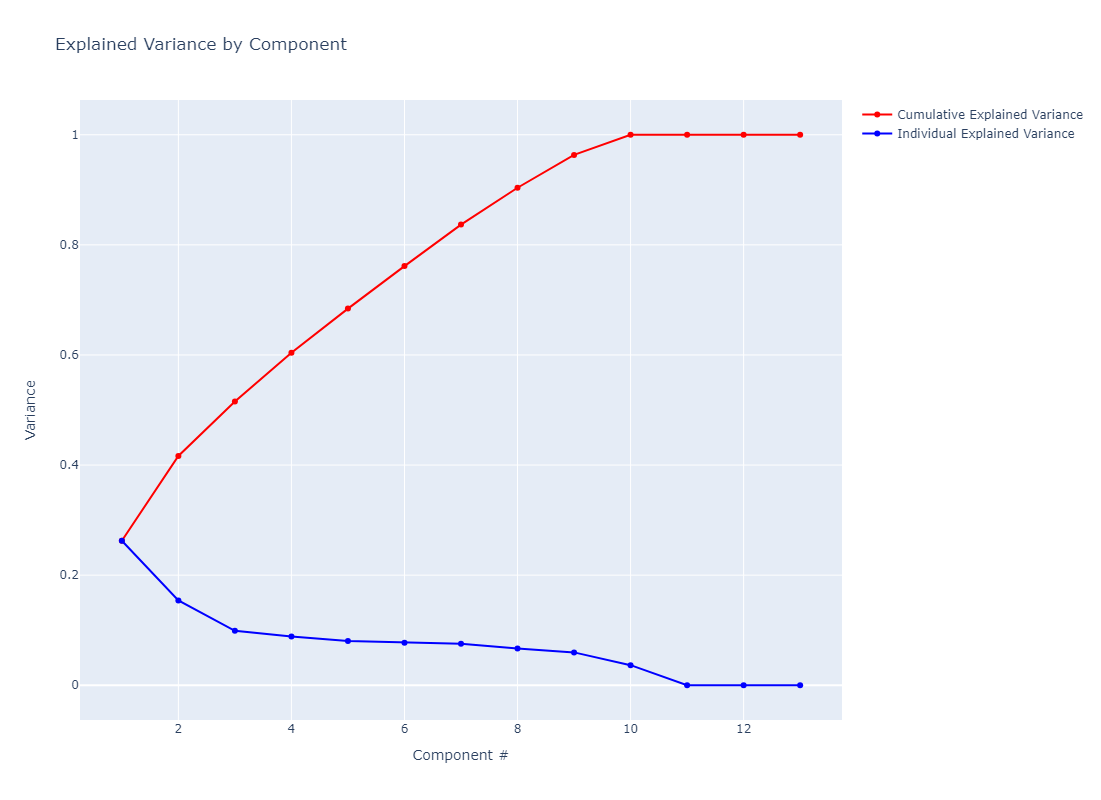

t_unix         t_tid       tid     orbit       alt  \
Principal Component 1   0.527297  1.121533e-02  0.526949  0.526950  0.033709   
Principal Component 2   0.011188  1.288094e-02  0.011396  0.011395  0.037099   
Principal Component 3   0.024157  6.597776e-01  0.023428  0.023444  0.622953   
Principal Component 4   0.162619  4.603405e-01  0.164962  0.164954  0.363162   
Principal Component 5   0.026390  5.455153e-02  0.029920  0.029919  0.009657   
Principal Component 6   0.008150  6.224750e-02  0.009774  0.009775  0.046056   
Principal Component 7   0.015626  1.189802e-01  0.019945  0.019948  0.144563   
Principal Component 8   0.111422  1.450453e-01  0.110629  0.110615  0.372248   
Principal Component 9   0.063392  1.773955e-01  0.065263  0.065276  0.405850   
Principal Component 10  0.100889  5.281797e-01  0.100765  0.100775  0.388757   
Principal Component 11  0.000941  5.785019e-04  0.000967  0.000985  0.001561   
Principal Component 12  0.816813  2.943585e-04  0.408038  0.407786  0.000352   
Principal Component 13  0.000145  2.337477e-07  0.707034  0.707180  0.000019   

                                 lst          long       lat           sza  \
Principal Component 1   2.321558e-01  1.261093e-03  0.127438  3.041843e-01   
Principal Component 2   3.704295e-02  4.035359e-03  0.021238  4.500334e-04   
Principal Component 3   1.644408e-01  1.374128e-02  0.129396  1.431960e-01   
Principal Component 4   9.554771e-02  1.346745e-03  0.294167  5.370867e-01   
Principal Component 5   1.951942e-01  4.442322e-02  0.489335  1.276540e-01   
Principal Component 6   5.202852e-02  9.181798e-01  0.242862  1.391000e-02   
Principal Component 7   1.791872e-01  3.928612e-01  0.618973  5.326255e-02   
Principal Component 8   6.973441e-01  2.016731e-02  0.064614  1.180057e-01   
Principal Component 9   5.903690e-01  4.059130e-03  0.375891  2.926880e-01   
Principal Component 10  2.860727e-02  8.679800e-04  0.230163  6.925213e-01   
Principal Component 11  1.533041e-03  8.804803e-05  0.001173  4.184713e-04   
Principal Component 12  6.636263e-04  3.718556e-05  0.005233  1.009726e-03   
Principal Component 13  7.029504e-07  1.523180e-07  0.000001  4.451535e-07   

                            mass  abundance  precision       cps  
Principal Component 1   0.020246   0.015135   0.042664  0.014767  
Principal Component 2   0.049309   0.704829   0.017691  0.704773  
Principal Component 3   0.086141   0.034300   0.317134  0.035949  
Principal Component 4   0.063349   0.018127   0.431847  0.019271  
Principal Component 5   0.657283   0.030195   0.514586  0.029925  
Principal Component 6   0.295804   0.003873   0.035836  0.003262  
Principal Component 7   0.612025   0.013274   0.128877  0.011534  
Principal Component 8   0.187240   0.017949   0.512794  0.019220  
Principal Component 9   0.236672   0.003153   0.399649  0.004800  
Principal Component 10  0.023608   0.003089   0.073702  0.005230  
Principal Component 11  0.000990   0.707133   0.000539  0.707073  
Principal Component 12  0.000013   0.001133   0.000019  0.001088  
Principal Component 13  0.000001   0.000009   0.000003  0.000009

In [63]:
sample_pca_data = sample2017.drop(['t_utc', 'focusmode'], axis=1)
pca_2017, pca_model_2017 = applyPCA(sample_pca_data)
PCA_Summary(pca_model_2017, sample_pca_data.columns, 'PCA_2017_time')

In [64]:
PCA_ScatterBy(sample2017, sample_pca_data.columns, pca_2017, pca_model_2017, 't_unix', 'PCA_2017_time')
PCA_ScatterBy(sample2017, sample_pca_data.columns, pca_2017, pca_model_2017, 'mass', 'PCA_2017_time')
PCA_ScatterBy(sample2017, sample_pca_data.columns, pca_2017, pca_model_2017, 'alt', 'PCA_2017_time')
PCA_ScatterBy(sample2017, sample_pca_data.columns, pca_2017, pca_model_2017, 'abundance', 'PCA_2017_time')

In [65]:
sample_pca_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   t_unix     100000 non-null  float64
 1   t_tid      100000 non-null  float64
 2   tid        100000 non-null  int64  
 3   orbit      100000 non-null  int64  
 4   alt        100000 non-null  float64
 5   lst        100000 non-null  float64
 6   long       100000 non-null  float64
 7   lat        100000 non-null  float64
 8   sza        100000 non-null  float64
 9   mass       100000 non-null  float64
 10  abundance  100000 non-null  float64
 11  precision  100000 non-null  float64
 12  cps        100000 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 9.9 MB


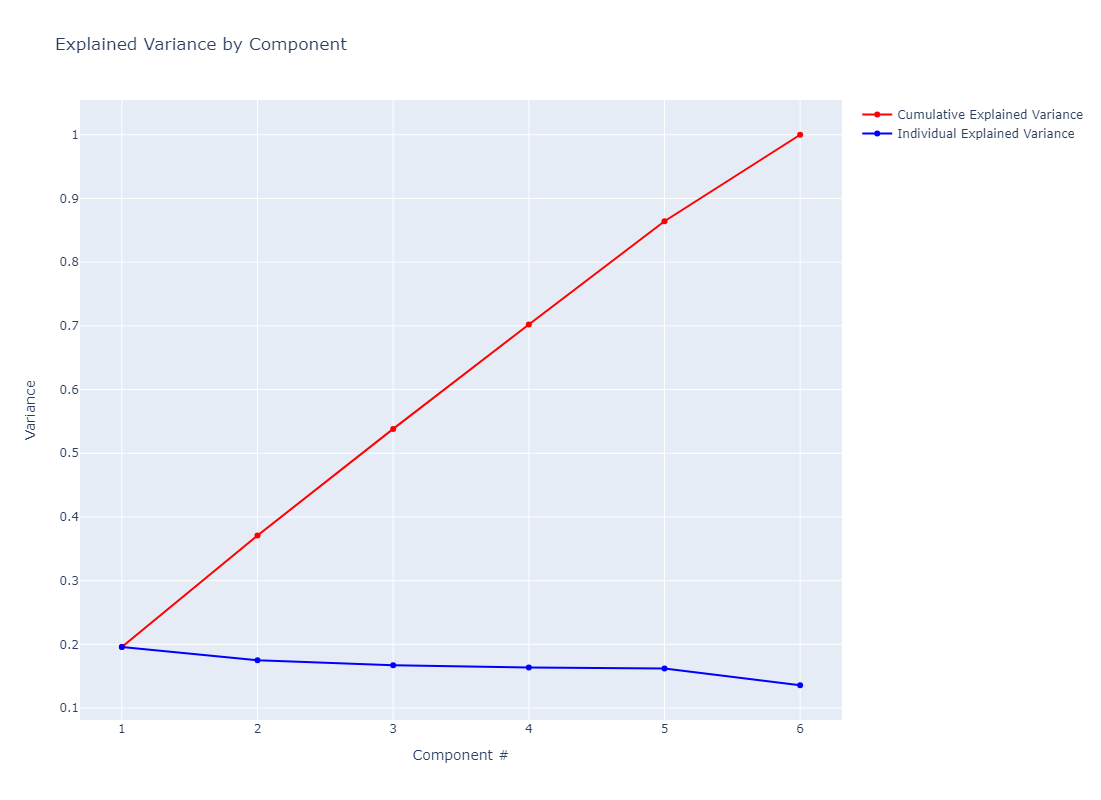

alt      long       lat      mass  abundance  \
Principal Component 1  0.703170  0.017865  0.222790  0.148869   0.179788   
Principal Component 2  0.017045  0.041347  0.340163  0.696419   0.486088   
Principal Component 3  0.043168  0.911850  0.334158  0.233216   0.024486   
Principal Component 4  0.014998  0.309357  0.805337  0.105319   0.481045   
Principal Component 5  0.205873  0.265895  0.250906  0.566770   0.705995   
Principal Component 6  0.678814  0.009944  0.107103  0.325773   0.031012   

                       precision  
Principal Component 1   0.633333  
Principal Component 2   0.401256  
Principal Component 3   0.003970  
Principal Component 4   0.114058  
Principal Component 5   0.065620  
Principal Component 6   0.648499

In [66]:
pca_data2017_nt = sample_pca_data.drop(['t_unix', 't_tid', 'tid', 'orbit', 'lst', 'sza', 'cps'], axis=1)
pca_2017_nt, pca_model_2017_nt = applyPCA(pca_data2017_nt)
PCA_Summary(pca_model_2017_nt, pca_data2017_nt.columns, '2017_PCA_no_time')

In [67]:
PCA_ScatterBy(sample2017, pca_data2017_nt.columns, pca_2017_nt, pca_model_2017_nt, 'alt', 'PCA_2017_no_time')
PCA_ScatterBy(sample2017, pca_data2017_nt.columns, pca_2017_nt, pca_model_2017_nt, 'mass', 'PCA_2017_no_time')
PCA_ScatterBy(sample2017, pca_data2017_nt.columns, pca_2017_nt, pca_model_2017_nt, 'abundance', 'PCA_2017_no_time')

In [319]:
sample2017m = sample2017m[(sample2017m['abundance'] < 10**10) & (sample2017['abundance'] > 1)]
pca_data2017m_nt = sample2017m.drop(['t_utc', 'focusmode', 't_unix', 't_tid', 'tid', 'orbit', 'lst', 'sza', 'cps'], axis=1)
pca_2017m_nt, pca_model_2017m_nt = applyPCA(pca_data2017m_nt)
PCA_Summary(pca_model_2017m_nt, pca_data2017m_nt.columns, '2017_PCA_time')

In [231]:
PCA_ScatterBy(sample2017m, pca_data2017m_nt.columns, pca_2017m_nt, pca_model_2017m_nt, 'alt', 'PCA_2017m_no_time')
PCA_ScatterBy(sample2017m, pca_data2017m_nt.columns, pca_2017m_nt, pca_model_2017m_nt, 'mass', 'PCA_2017m_no_time')
PCA_ScatterBy(sample2017m, pca_data2017m_nt.columns, pca_2017m_nt, pca_model_2017m_nt, 'abundance', 'PCA_2017m_no_time')

In [233]:
def PCA_ScatterBy3D(DataFrame, features, pca, pca_model, hue, filename):
    hover_data = {feat: DataFrame[feat] for feat in DataFrame.columns}

    loadings = pca_model.components_.T * np.sqrt(pca_model.explained_variance_)
    total_var = pca_model.explained_variance_ratio_[:3].sum() * 100

    fig = px.scatter_3d(pca, x=0, y=1, z=2, height=800, width=1000, color=DataFrame[hue], 
                        color_continuous_scale='plasma', labels={'color': hue}, 
                        hover_data=hover_data, title='PCA 3D Scatter {} by {} TEV {:.2f}%'.format(filename, hue, total_var))

    fig.update_traces(marker_size=2)

    for j, feature in enumerate(features):
        fig.add_trace(go.Scatter3d(
            x=[0, loadings[j, 0]*5],
            y=[0, loadings[j, 1]*5],
            z=[0, loadings[j, 2]*5],
            mode='lines',
            line=dict(color='black', width=8),
            showlegend=False
        ))

    fig.update_layout(
        scene=dict(
            xaxis=dict(type="linear"),
            yaxis=dict(type="linear"),
            zaxis=dict(type="linear"),
            annotations=[dict(
                x=loadings[j, 0]*5,
                y=loadings[j, 1]*5,
                z=loadings[j, 2]*5,
                ax=0, ay=0,
                xanchor="center", yanchor="bottom",
                text=feature,
                font=dict(color='black', size=15),
                showarrow=True,
                arrowhead=2) for j, feature in enumerate(features)]))

    if plotly_display == True:
        fig.show()

    fig.write_html('PCA_3D_Scatter_{}_by_{}.html'.format(filename, hue))


PCA_ScatterBy3D(sample2017m, pca_data2017m_nt.columns, pca_2017m_nt, pca_model_2017m_nt, 'alt', 'PCA_2017m_no_time')

In [235]:
PCA_ScatterBy3D(sample2017m, pca_data2017m_nt.columns, pca_2017m_nt, pca_model_2017m_nt, 'mass', 'PCA_2017m_no_time')
PCA_ScatterBy3D(sample2017m, pca_data2017m_nt.columns, pca_2017m_nt, pca_model_2017m_nt, 'abundance', 'PCA_2017m_no_time')

In [329]:
pca_data2017m_nt_log = pca_data2017m_nt.drop(['precision'], axis=1)
pca_data2017m_nt_log['abundance'] = np.log10(pca_data2017m_nt_log['abundance'])
pca_data2017m_nt_log = pca_data2017m_nt_log.rename(columns={'abundance': 'log_abundance'})
pca_data2017m_nt_log = pca_data2017m_nt_log[(pca_data2017m_nt_log['log_abundance'] != -np.inf) & pca_data2017m_nt_log['log_abundance'].notnull()]
pca_data2017m_nt_log.info()
pca_data2017m_nt_log.head()

<class 'pandas.core.frame.DataFrame'>
Index: 56524 entries, 4 to 99999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   alt            56524 non-null  float64
 1   long           56524 non-null  float64
 2   lat            56524 non-null  float64
 3   mass           56524 non-null  float64
 4   log_abundance  56524 non-null  float64
dtypes: float64(5)
memory usage: 4.6 MB


alt       long        lat  mass  log_abundance
4   159.0732   20.24027  52.894540  16.0       8.172415
5   265.6693  106.23440 -67.489180  29.0       2.360648
6   268.7126  106.69990  -1.959894  43.0       0.481500
7   152.1142  -61.19179  68.771750  43.0       1.830009
14  445.2776  -19.67710  60.521790  40.0       2.297121

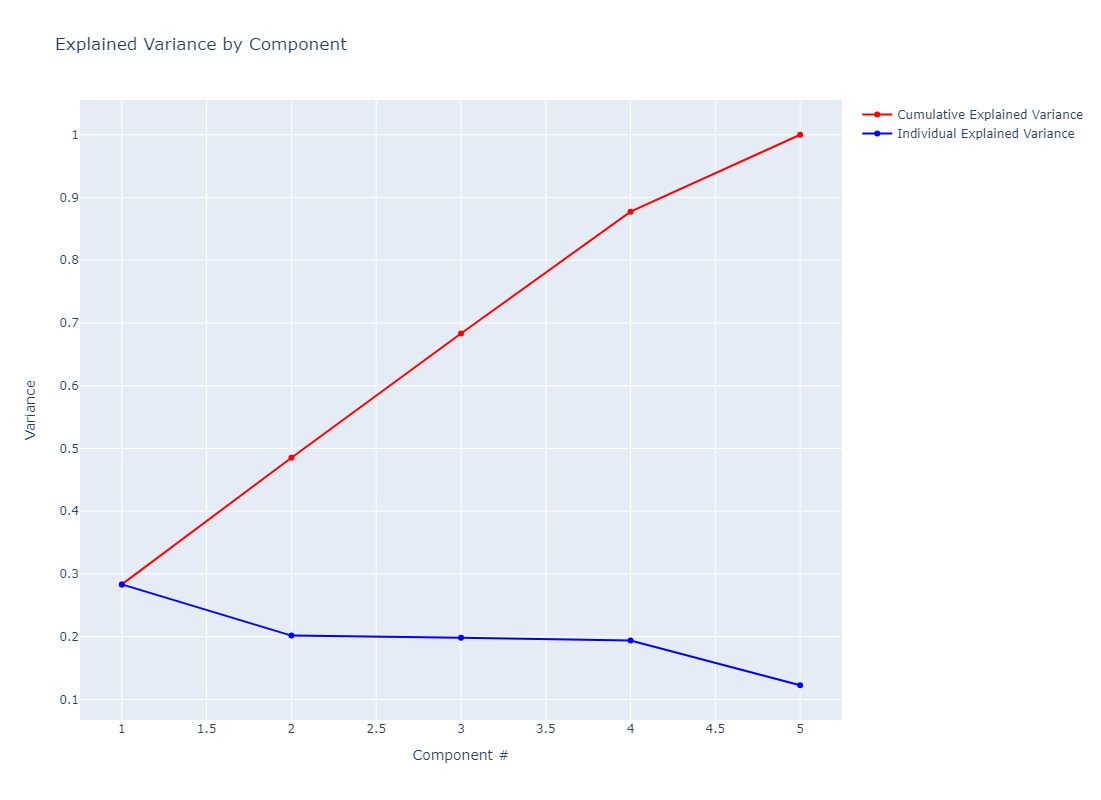

alt      long       lat      mass  log_abundance
Principal Component 1  0.689796  0.036752  0.224787  0.347605       0.592852
Principal Component 2  0.050885  0.750618  0.460894  0.372678       0.287527
Principal Component 3  0.044602  0.604449  0.192888  0.638615       0.433148
Principal Component 4  0.086610  0.263619  0.833547  0.475377       0.047108
Principal Component 5  0.715613  0.019221  0.070998  0.326296       0.613204

In [331]:
pca_2017m_ntl, pca_model_2017m_ntl = applyPCA(pca_data2017m_nt_log)
PCA_Summary(pca_model_2017m_ntl, pca_data2017m_nt_log.columns, '2017_PCA_time_log')

In [349]:
sample2017ml = sample2017m[~(np.log10(sample2017['abundance']).isin([-np.inf, np.nan])) & (sample2017['abundance'] > 1)]
sample2017ml['log_abundance'] = np.log10(sample2017ml['abundance'])
sample2017ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56524 entries, 4 to 99999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   t_utc          56524 non-null  datetime64[ns]
 1   t_unix         56524 non-null  float64       
 2   t_tid          56524 non-null  float64       
 3   tid            56524 non-null  int64         
 4   orbit          56524 non-null  int64         
 5   focusmode      56524 non-null  object        
 6   alt            56524 non-null  float64       
 7   lst            56524 non-null  float64       
 8   long           56524 non-null  float64       
 9   lat            56524 non-null  float64       
 10  sza            56524 non-null  float64       
 11  mass           56524 non-null  float64       
 12  abundance      56524 non-null  float64       
 13  precision      56524 non-null  float64       
 14  cps            56524 non-null  float64       
 15  log_abundance  56524 non

In [341]:
PCA_ScatterBy(sample2017ml, pca_data2017m_nt_log.columns, pca_2017m_ntl, pca_model_2017m_ntl, 'alt', 'PCA_2017m_no_time_log')
PCA_ScatterBy(sample2017ml, pca_data2017m_nt_log.columns, pca_2017m_ntl, pca_model_2017m_ntl, 'mass', 'PCA_2017m_no_time_log')
PCA_ScatterBy(sample2017ml, pca_data2017m_nt_log.columns, pca_2017m_ntl, pca_model_2017m_ntl, 'log_abundance', 'PCA_2017m_no_time_log')

In [345]:
PCA_ScatterBy3D(sample2017ml, pca_data2017m_nt_log.columns, pca_2017m_ntl, pca_model_2017m_ntl, 'alt', 'PCA_2017m_no_time_log')
PCA_ScatterBy3D(sample2017ml, pca_data2017m_nt_log.columns, pca_2017m_ntl, pca_model_2017m_ntl, 'mass', 'PCA_2017m_no_time_log')
PCA_ScatterBy3D(sample2017ml, pca_data2017m_nt_log.columns, pca_2017m_ntl, pca_model_2017m_ntl, 'log_abundance', 'PCA_2017m_no_time_log')

In [351]:
L2_ScatterBy(sample2017ml, 'alt', 'log_abundance')

In [479]:
import umap

def applyUMAP(data, n=2, n_neighbors=15):
    reducer = umap.UMAP(n_components=n)
    scaled_data = StandardScaler().fit_transform(data)
    embedding = reducer.fit_transform(scaled_data)

    return embedding

embedding2017_ntl = applyUMAP(pca_data2017m_nt_log.values)

In [447]:
def UMAP_ScatterBy(embedding, sample_data, title, hue=None, r_3=False):
    if not r_3:
        fig = px.scatter(embedding, 
                         x=0, y=1, 
                         height=800, width=1000, 
                         color=sample_data[hue], 
                         color_continuous_scale='plasma', 
                         labels={'color': hue}, 
                         hover_data={feat: sample_data[feat] for feat in sample_data.columns}, 
                         title='UMAP 2D Scatter {} by {}'.format(title, hue,))
    else:
        fig = px.scatter_3d(embedding, 
                    x=0, y=1, z=2, 
                    height=800, width=1000, 
                    color=sample_data[hue], 
                    color_continuous_scale='plasma', 
                    labels={'color': hue}, 
                    hover_data={feat: sample_data[feat] for feat in sample_data.columns}, 
                    title='UMAP 3D Scatter {} by {}'.format(title, hue))

        fig.update_traces(marker_size=2)

    if plotly_display == True:
        fig.show()
        
        
    fig.write_html('UMAP_{}D_Scatter_{}_by_{}.html'.format('3' if r_3 else '2', title, hue))

UMAP_ScatterBy(embedding2017_ntl, sample2017ml, '2017_no_time_log', hue='mass')

In [448]:
UMAP_ScatterBy(embedding2017_ntl, sample2017ml, '2017_no_time_log', hue='alt')
UMAP_ScatterBy(embedding2017_ntl, sample2017ml, '2017_no_time', hue='log_abundance')

In [451]:
embedding2017_ntl_3d = applyUMAP(pca_data2017m_nt_log.values, n=3)
UMAP_ScatterBy(embedding2017_ntl_3d, sample2017ml, '2017_no_time_log', hue='mass', r_3=True)

In [453]:
UMAP_ScatterBy(embedding2017_ntl_3d, sample2017ml, '2017_no_time_log', hue='alt', r_3=True)
UMAP_ScatterBy(embedding2017_ntl_3d, sample2017ml, '2017_no_time_log', hue='log_abundance', r_3=True)

In [455]:
embedding2017_t = applyUMAP(sample_pca_data)
UMAP_ScatterBy(embedding2017_t, sample2017, '2017_time', hue='mass')

In [481]:
sample2017ml_high_mass = sample2017ml[sample2017ml['mass'] > 10]
data2017ml_high_mass = sample2017ml_high_mass.drop(['t_utc', 'focusmode', 'abundance'], axis=1).values
embedding2017_tl_hm = applyUMAP(data2017ml_high_mass, n_neighbors=25)
embedding2017_tl_hm_3d = applyUMAP(data2017ml_high_mass, n=3, n_neighbors=25)

UMAP_ScatterBy(embedding2017_tl_hm, sample2017ml_high_mass, '2017_time_high_mass_n=25', hue='mass')
UMAP_ScatterBy(embedding2017_tl_hm_3d, sample2017ml_high_mass, '2017_time_high_mass_n=25', hue='mass', r_3=True)

In [457]:
embedding2017_nt = applyUMAP(pca_data2017m_nt.values)
UMAP_ScatterBy(embedding2017_nt, sample2017m, '2017_no_time', hue='mass')

In [491]:
sample2017ml_hm = sample2017m_high_mass
sample2017ml_hm['log_abundance'] = np.log10(sample2017ml_hm['abundance'])

In [485]:
embedding2017_ntl_hm = applyUMAP(pca_data2017m_nt_log.loc[sample2017m_high_mass.index])
UMAP_ScatterBy(embedding2017_ntl_hm, sample2017ml_hm, '2017_no_time_high_mass', hue='mass')

In [493]:
UMAP_ScatterBy(embedding2017_ntl_hm, sample2017ml_hm, '2017_no_time_high_mass', hue='alt')
UMAP_ScatterBy(embedding2017_ntl_hm, sample2017ml_hm, '2017_no_time_high_mass', hue='log_abundance')

In [495]:
embedding2017_ntl_hm = applyUMAP(pca_data2017m_nt_log.loc[sample2017m_high_mass.index], n=3)
UMAP_ScatterBy(embedding2017_ntl_hm, sample2017ml_hm, '2017_no_time_high_mass', hue='mass', r_3=True)

In [497]:
UMAP_ScatterBy(embedding2017_ntl_hm, sample2017ml_hm, '2017_no_time_high_mass', hue='alt', r_3=True)
UMAP_ScatterBy(embedding2017_ntl_hm, sample2017ml_hm, '2017_no_time_high_mass', hue='log_abundance', r_3=True)